# 채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!

https://dacon.io/competitions/official/236450/overview/description

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1
!pip install catboost

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 811.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
# 나눔폰트 설치
# 코드 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,605 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and dire

# 폰트 설치 및 모듈 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/YB_project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/YB_project/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/YB_project/sample_submission.csv')

In [ ]:
train.drop(columns=['UID'], inplace=True)
test.drop(columns=['UID'], inplace=True)

In [ ]:
train.head()

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0


In [ ]:
train['채무 불이행 여부'].value_counts()

,count
채무 불이행 여부,
0,6588
1,3412


In [ ]:
train.shape

(10000, 17)

In [ ]:
test.shape

(2062, 16)

# 변수 간 상관관계 분석

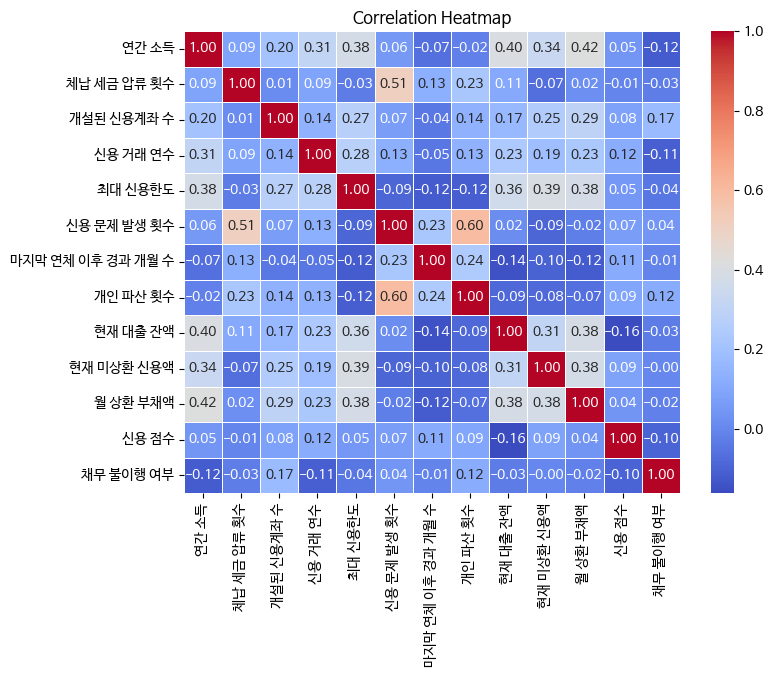

In [ ]:
corr_matrix = train.corr(numeric_only = True)

# 히트맵 생성
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 피처엔지니어링(새로운 변수 추가)

[부채 수준]
- 총부채 = 현재 대출 잔액 + 현재 미상환 신용액
- 총 부채 비율 = ( 현재 대출 잔액 + 현재 미상환 신용액 ) / 연간 소득 = 총 부채 / 연간 소득
- DTI = (월 상환 부채액 * 12) / 연간 소득
- 대출 대 소득 비율 = 현재 대출 잔액 / 연간 소득
- DSR = 월 상환 부채액 / (연간소득/12)

[신용 형태]
- 신용 사용률 = 현재 미상환 신용액 / 최대 신용한도
- 신용카드 사용 집중도 = 현재 미상환 신용액 / (현재 대출 잔액 + 현재 미상환 신용액)
- 신용 거래당 신용 문제 발생률 = 신용 문제 발생 횟수 / 신용 거래 연수
- 고위험 지표 = 체납 세금 압류 횟수 + 신용 문제 발생 횟수 + 개인 파산 횟수
- 신용 이벤트 발생 빈도 = (체납 세금 압류 횟수 + 신용 문제 발생 횟수 + 개인 파산 횟수) / 신용 거래 연수
- 신규 계좌 개설 빈도 = 개설된 신용 계좌 수 / 신용 거래 연수

[대출 형태]
- 대출목적_연체율

[연체 여부]
- 정상 거래 기간 = 마지막 연체 이후 경과 개월 수 / 신용 거래 연수
- 1년 내 연체 여부
- 최근 연체 여부
- 연체 경험 여부

In [ ]:
## 총 부채
train['총 부채'] = train['현재 대출 잔액'] + train['현재 미상환 신용액']
test['총 부채'] = test['현재 대출 잔액'] + test['현재 미상환 신용액']

In [ ]:
## 총 부채 비율
train['총 부채 비율'] = (train['현재 대출 잔액'] + train['현재 미상환 신용액']) / train['연간 소득']
test['총 부채 비율'] = (test['현재 대출 잔액'] + test['현재 미상환 신용액']) / test['연간 소득']

In [ ]:
## DTI 비율 계산
train["DTI"] = (train["월 상환 부채액"] * 12) / train["연간 소득"]
test["DTI"] = (test["월 상환 부채액"] * 12) / test["연간 소득"]

In [ ]:
train["대출 대 소득 비율"] = train["현재 대출 잔액"] / (train["연간 소득"])
test["대출 대 소득 비율"] = test["현재 대출 잔액"] / (test["연간 소득"])

In [ ]:
train["DSR"] = train["월 상환 부채액"] / (train["연간 소득"] / 12)
test["DSR"] = test["월 상환 부채액"] / (test["연간 소득"] / 12)

In [ ]:
train['신용카드 사용 집중도'] = train['현재 미상환 신용액'] / (train['현재 대출 잔액']+train['현재 미상환 신용액'])
test['신용카드 사용 집중도'] = test['현재 미상환 신용액'] / (test['현재 대출 잔액']+test['현재 미상환 신용액'])

In [ ]:
## 고위험 지표 생성
train["고위험 지표"] = train["체납 세금 압류 횟수"] + train["신용 문제 발생 횟수"] + train["개인 파산 횟수"]
test["고위험 지표"] = test["체납 세금 압류 횟수"] + test["신용 문제 발생 횟수"] + test["개인 파산 횟수"]

In [ ]:
train['신용 이벤트 발생 빈도'] = (train['체납 세금 압류 횟수']+train['신용 문제 발생 횟수']+train['개인 파산 횟수'])/train['신용 거래 연수']
test['신용 이벤트 발생 빈도'] = (test['체납 세금 압류 횟수']+test['신용 문제 발생 횟수']+test['개인 파산 횟수'])/test['신용 거래 연수']

In [ ]:
train['신규 계좌 개설 빈도'] = train['개설된 신용계좌 수']/train['신용 거래 연수']
test['신규 계좌 개설 빈도'] = test['개설된 신용계좌 수']/test['신용 거래 연수']

In [ ]:
default_rate_by_purpose = train.groupby("대출 목적")["채무 불이행 여부"].mean()
train["대출목적_연체율"] = train["대출 목적"].map(default_rate_by_purpose)
test["대출목적_연체율"] = test["대출 목적"].map(default_rate_by_purpose)

In [ ]:
train.groupby('대출 목적')['대출목적_연체율'].mean().sort_values(ascending=False)

,대출목적_연체율
대출 목적,
부채 통합,0.398547
휴가 비용,0.333333
기타,0.217526
의료비,0.196203
사업 대출,0.185039
주택 개보수,0.174917
여행 자금,0.161850
주택 구매,0.153846
결혼 자금,0.142857


In [ ]:
train["1년 내 연체 여부"] = train["마지막 연체 이후 경과 개월 수"].apply(lambda x: 1 if x < 12 else 0)
test["1년 내 연체 여부"] = test["마지막 연체 이후 경과 개월 수"].apply(lambda x: 1 if x < 12 else 0)

In [ ]:
'''
## 최근 연체 여부 생성 (마지막 연체 이후 경과 개월 수가 0이면 1, 아니면 0)
train["최근 연체 여부"] = (train["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test["최근 연체 여부"] = (test["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
'''

'\n## 최근 연체 여부 생성 (마지막 연체 이후 경과 개월 수가 0이면 1, 아니면 0)\ntrain["최근 연체 여부"] = (train["마지막 연체 이후 경과 개월 수"] == 0).astype(int)\ntest["최근 연체 여부"] = (test["마지막 연체 이후 경과 개월 수"] == 0).astype(int)\n'

In [ ]:
## 연체 경험 여부
train['연체 경험 여부'] = (train['신용 문제 발생 횟수'] > 0).astype(int)
test['연체 경험 여부'] = (test['신용 문제 발생 횟수'] > 0).astype(int)

# 데이터 전처리 (이상치 확인 및 로그변환)

## 주거형태

In [ ]:
# 주거형태
display(train['주거 형태'].value_counts())
display(test['주거 형태'].value_counts())

,count
주거 형태,
월세,4050
주택 담보 대출 (거주 중),3633
자가,2241
주택 담보 대출 (비거주 중),76


,count
주거 형태,
주택 담보 대출 (거주 중),1052
월세,830
자가,175
주택 담보 대출 (비거주 중),5


## ❗연간 소득 : 로그 변환

<Axes: ylabel='연간 소득'>

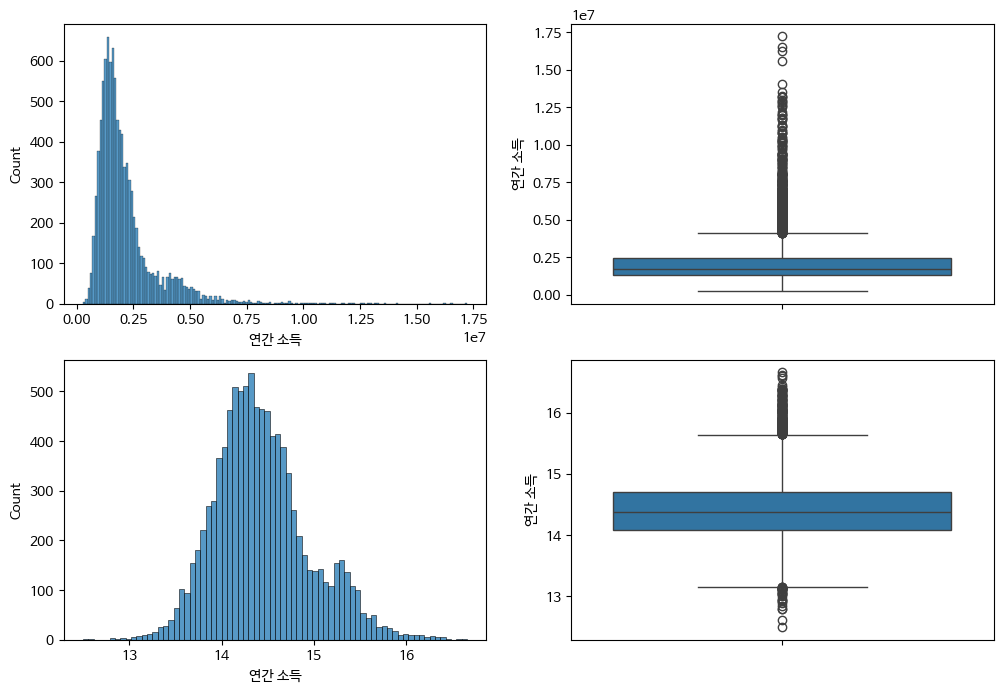

In [ ]:
# 연간 소득
fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.histplot(train['연간 소득'], ax=ax[0][0])
sns.boxplot(train['연간 소득'], ax=ax[0][1])
sns.histplot(np.log1p(train['연간 소득']), ax=ax[1][0])
sns.boxplot(np.log1p(train['연간 소득']), ax=ax[1][1])

In [ ]:
# 로그 변환 진행
train['연간 소득'] = np.log1p(train['연간 소득'])
test['연간 소득'] = np.log1p(test['연간 소득'])

In [ ]:
# 왜도, 첨도 계산
from scipy.stats import skew, kurtosis

# 왜도
print(f"skewness: {skew(train['연간 소득']):.6f}")
# 첨도
print(f"kurtosis: {kurtosis(train['연간 소득'], fisher=True):.6f}")

skewness: 0.578835
kurtosis: 0.560658


In [ ]:
# test 데이터 왜도, 첨도 계산 -> 확인용. 셀 삭제해야함

print(f"skewness: {skew(test['연간 소득']):.6f}")
print(f"kurtosis: {kurtosis(test['연간 소득'], fisher=True):.6f}")

skewness: 0.274134
kurtosis: 0.793936


## ❗현재 직장 근속 연수 : 숫자형 변환

In [ ]:
# 현재 직장 근속 연수
display(train['현재 직장 근속 연수'].value_counts())
display(test['현재 직장 근속 연수'].value_counts())

,count
현재 직장 근속 연수,
10년 이상,3828
2년,1225
8년,841
5년,729
7년,619
1년,581
4년,541
3년,523
1년 미만,488


,count
현재 직장 근속 연수,
10년 이상,753
2년,188
3년,165
1년 미만,145
5년,144
4년,140
1년,136
7년,121
6년,100


In [ ]:
# '현재 직장 근속연수' 칼럼을 변환하는 함수
def convert_years(value):
    if '년 이상' in value:
        # '년 이상'이 포함된 값은 숫자만 추출
        return int(value.split('년')[0])
    elif '년 미만' in value:
        # '1년 미만'의 경우 0으로 변환
        return int(value.split('년')[0])-1
    elif '년' in value:
        # '년'만 있는 경우 숫자 추출
        return int(value.split('년')[0])

# 변환된 값을 데이터프레임에 적용
train['현재 직장 근속 연수'] = train['현재 직장 근속 연수'].apply(convert_years)
# test에 동일하게 적용
test['현재 직장 근속 연수'] = test['현재 직장 근속 연수'].apply(convert_years)

In [ ]:
# 변환이 잘 되었는지 확인
train['현재 직장 근속 연수'].value_counts()

,count
현재 직장 근속 연수,
10,3828
2,1225
8,841
5,729
7,619
1,581
4,541
3,523
0,488


In [ ]:
# 범주화할 필요가 있는지 확인
train.groupby('현재 직장 근속 연수')['채무 불이행 여부'].mean()

,채무 불이행 여부
현재 직장 근속 연수,
0,0.381148
1,0.487091
2,0.247347
3,0.397706
4,0.441774
5,0.274348
6,0.389356
7,0.366721
8,0.493460


어딘가를 기점으로 채무 불이행자 비율이 매우 커지거나 작아지거나 하는 부분이 없음 > 범주화 하지 않는 것이 더 낫다고 판단

+ "현재" 직장 근속 연수이므로 그 값이 1년 미만이라고 해도 직전 직장을 얼마나 다녔는지는 알 수 없음.

Text(0.5, 1.0, '채무 불이행자들의 근속 연수와 신용 거래 연수')

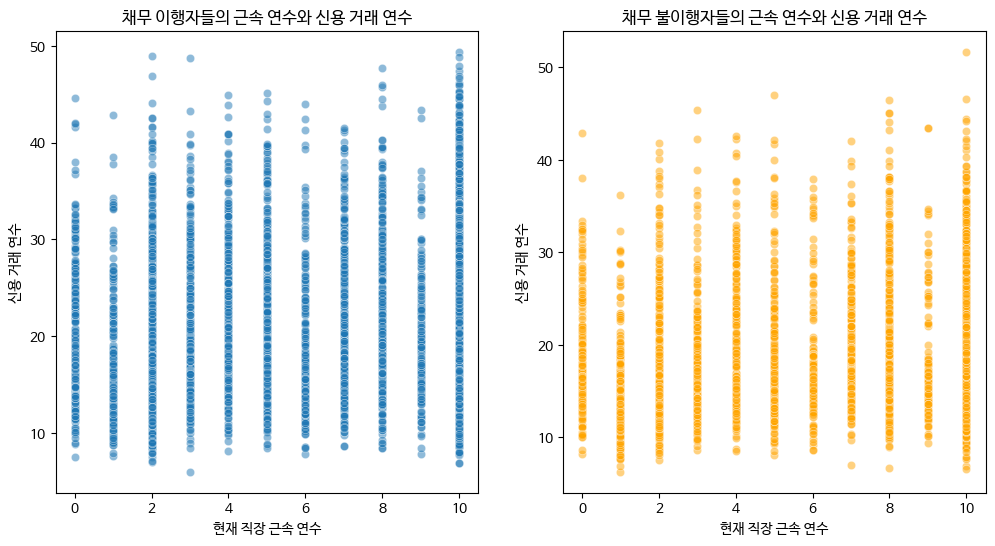

In [ ]:
# 직장 근속 연수 + 신용 거래 연수별 채무 불이행 여부 확인
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=train[train['채무 불이행 여부']==0], x='현재 직장 근속 연수', y='신용 거래 연수', ax=ax[0], alpha=0.5)
sns.scatterplot(data=train[train['채무 불이행 여부']==1], x='현재 직장 근속 연수', y='신용 거래 연수', ax=ax[1], alpha=0.5, color='orange')
ax[0].set_title('채무 이행자들의 근속 연수와 신용 거래 연수')
ax[1].set_title('채무 불이행자들의 근속 연수와 신용 거래 연수')

## 체납 세금 압류 횟수

In [ ]:
train['체납 세금 압류 횟수'].value_counts()

,count
체납 세금 압류 횟수,
0.0,8826
1.0,884
4.0,176
2.0,60
5.0,37
7.0,10
3.0,4
6.0,3


In [ ]:
display(train.groupby('체납 세금 압류 횟수')['채무 불이행 여부'].mean())

,채무 불이행 여부
체납 세금 압류 횟수,
0.0,0.342511
1.0,0.356335
2.0,0.383333
3.0,0.250000
4.0,0.210227
5.0,0.351351
6.0,0.000000
7.0,0.000000


## 개설된 신용계좌수

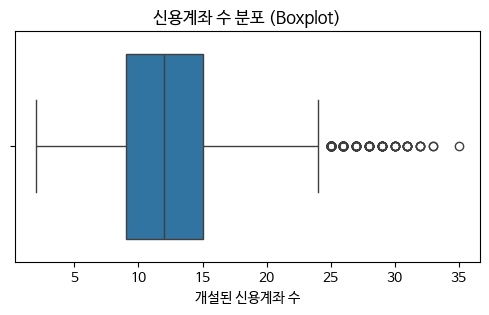

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "개설된 신용계좌 수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("신용계좌 수 분포 (Boxplot)")

plt.show()

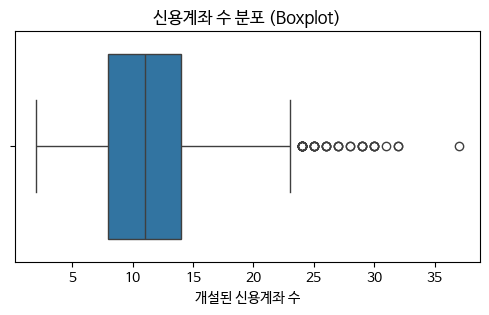

In [ ]:
### test 살펴보기

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "개설된 신용계좌 수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=test[column_name])
plt.title("신용계좌 수 분포 (Boxplot)")

plt.show()

## 신용 거래 연수

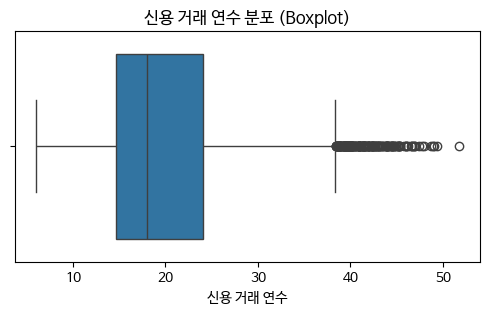

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신용 거래 연수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("신용 거래 연수 분포 (Boxplot)")

plt.show()

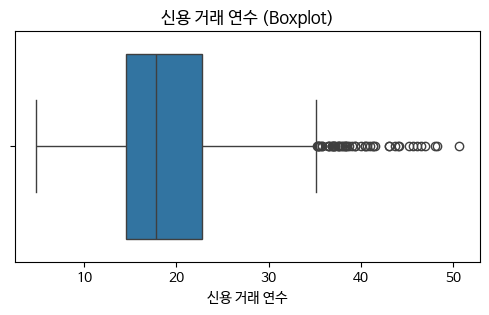

In [ ]:
### test 살펴보기

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신용 거래 연수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=test[column_name])
plt.title("신용 거래 연수 (Boxplot)")

plt.show()

## 최대 신용한도

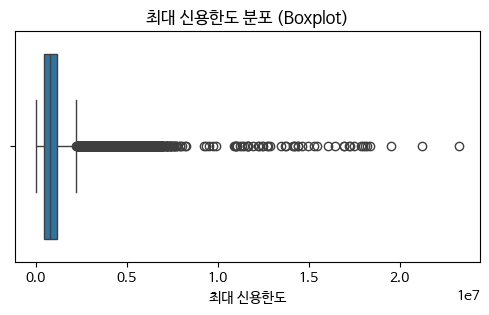

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "최대 신용한도"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("최대 신용한도 분포 (Boxplot)")

plt.show()

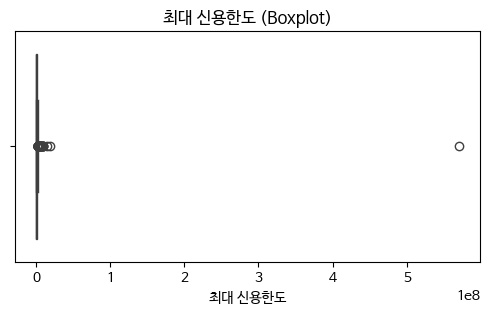

In [ ]:
### test 살펴보기

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "최대 신용한도"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=test[column_name])
plt.title("최대 신용한도 (Boxplot)")

plt.show()

In [ ]:
train[column_name].describe()

,최대 신용한도
count,1.000000e+04
mean,1.175265e+06
std,1.604199e+06
min,0.000000e+00
25%,4.482476e+05
50%,7.670910e+05
75%,1.147283e+06
max,2.323233e+07


In [ ]:
test[column_name].describe()

,최대 신용한도
count,2.062000e+03
mean,1.135118e+06
std,1.257305e+07
min,0.000000e+00
25%,3.758700e+05
50%,6.374115e+05
75%,1.047568e+06
max,5.700784e+08


## 신용 문제 발생 횟수

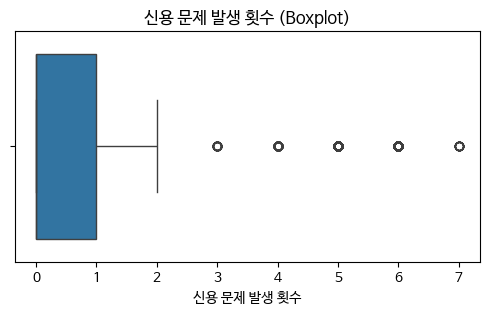

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신용 문제 발생 횟수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("신용 문제 발생 횟수 (Boxplot)")

plt.show()

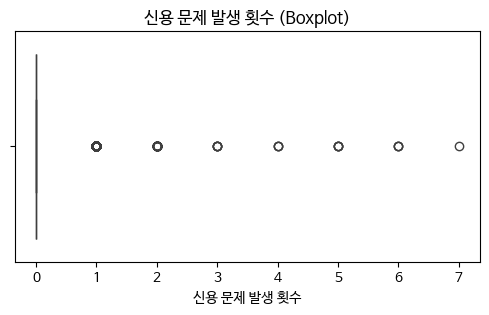

In [ ]:
### test 살펴보기

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신용 문제 발생 횟수"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=test[column_name])
plt.title("신용 문제 발생 횟수 (Boxplot)")

plt.show()

## 로그 변환 ("개설된 신용계좌 수", "신용 거래 연수", "최대 신용한도","신용 이벤트 발생 빈도", "신규 계좌 개설 빈도")

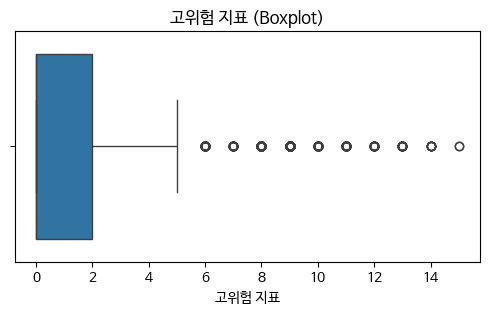

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "고위험 지표"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("고위험 지표 (Boxplot)")

plt.show()

=> 값의 범위가 크지 않기도 하고, 로그 변환을 모두 하지 않기로 한 변수들의 합일 뿐이므로 이 변수 역시 로그 변환 진행 x

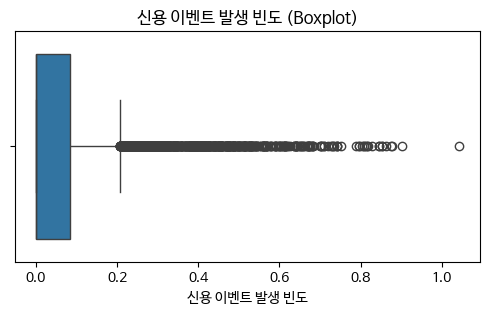

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신용 이벤트 발생 빈도"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("신용 이벤트 발생 빈도 (Boxplot)")

plt.show()

In [ ]:
count = (train[column_name] >= 10).sum()
print(f"고위험지표가 6 이상인 데이터 개수: {count}")

고위험지표가 6 이상인 데이터 개수: 0


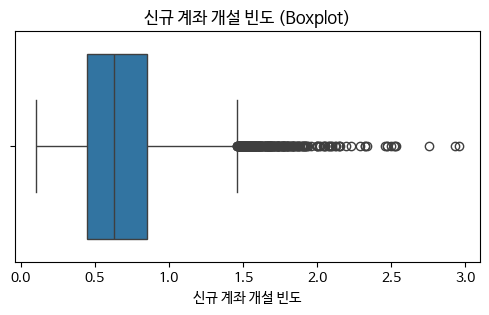

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "신규 계좌 개설 빈도"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("신규 계좌 개설 빈도 (Boxplot)")

plt.show()

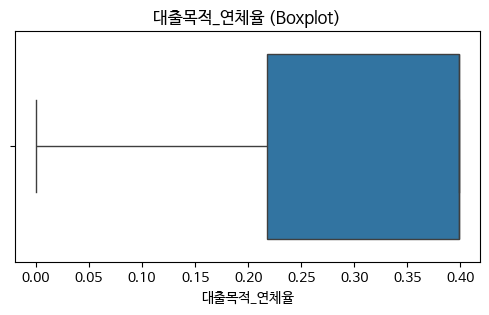

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 신용계좌 수 칼럼 이름 (실제 칼럼명을 사용해야 함)
column_name = "대출목적_연체율"

plt.figure(figsize=(6,3))

# 박스플롯
sns.boxplot(x=train[column_name])
plt.title("대출목적_연체율 (Boxplot)")

plt.show()

=> 평균 값 자체는 연속형이지만, 원래 범주형 데이터(대출목적, 채무불이행여부)에서 나온 값이므로 로그 변환 진행 놉

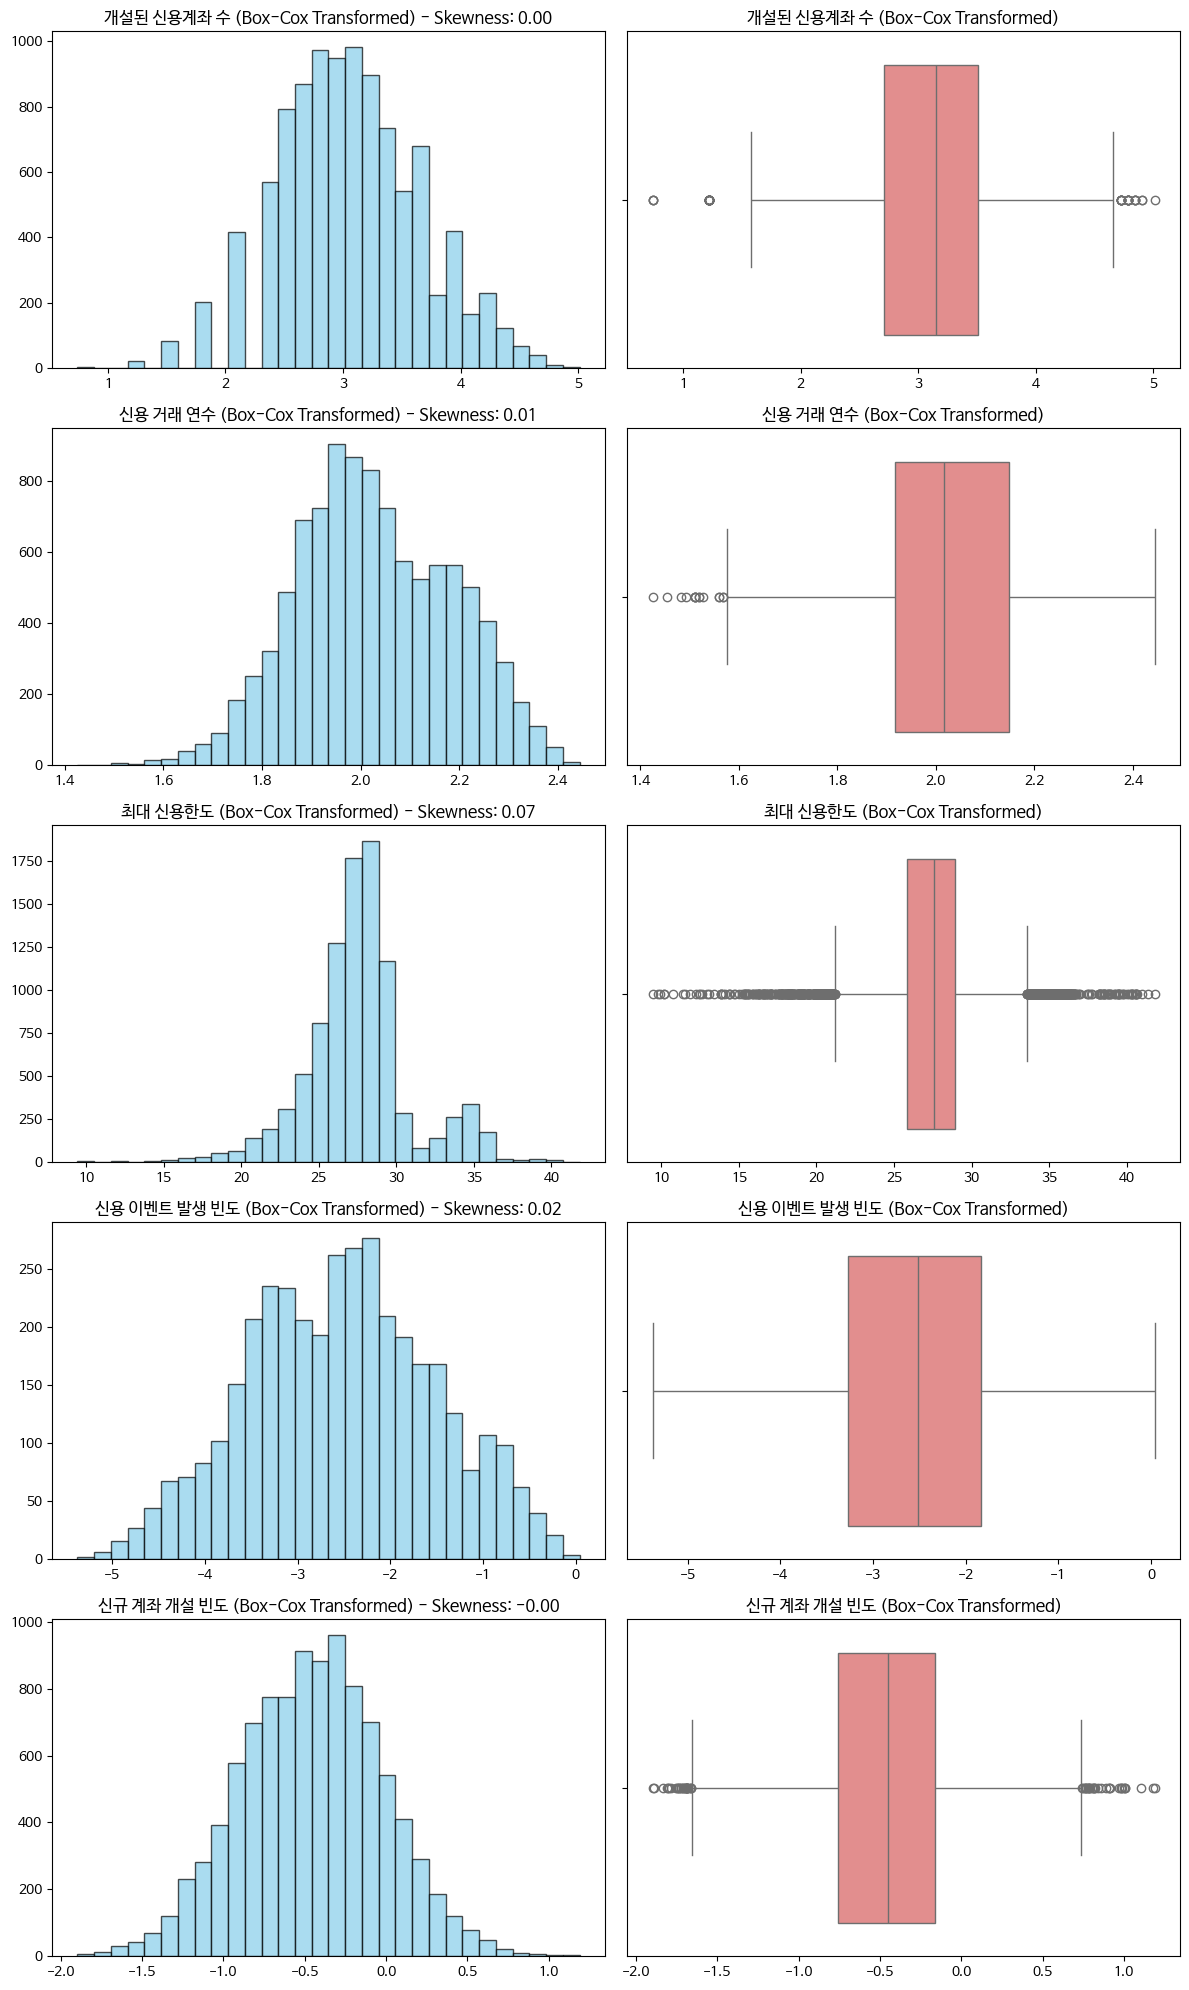

In [ ]:
import scipy.stats as stats

# Box-Cox 변환이 가능한 수치형 컬럼 선택
numeric_cols = [
    "개설된 신용계좌 수", "신용 거래 연수", "최대 신용한도",
    "신용 이벤트 발생 빈도", "신규 계좌 개설 빈도"
]

# 변환된 데이터를 저장할 딕셔너리
boxcox_transformed = {}

# 시각화 설정
plt.figure(figsize=(12, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    # 양수 값만 필터링 (Box-Cox 변환은 음수/0 값 불가능)
    positive_values = train[col][train[col] > 0]

    if len(positive_values) > 0:
        # Box-Cox 변환 수행
        transformed_data, lambda_ = stats.boxcox(positive_values)

        # 변환된 데이터 저장
        boxcox_transformed[col] = transformed_data

        # 왜도 계산
        skewness = stats.skew(transformed_data)

        # 시각화 (히스토그램 & 박스플롯)
        plt.subplot(len(numeric_cols), 2, 2 * i - 1)
        plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} (Box-Cox Transformed) - Skewness: {skewness:.2f}")

        plt.subplot(len(numeric_cols), 2, 2 * i)
        sns.boxplot(x=transformed_data, color='lightcoral')
        plt.title(f"{col} (Box-Cox Transformed)")

plt.tight_layout()
plt.show()

## 마지막 연체 이후 경과 개월 수

In [ ]:
# 추후 삭제할 코드 (test 데이터 사용)
'''
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 사이즈 설정
plt.figure(figsize=(12, 5))

# Train 데이터 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(y=train['마지막 연체 이후 경과 개월 수'])
plt.title('Train - 마지막 연체 이후 경과 개월 수')

# Test 데이터 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(y=test['마지막 연체 이후 경과 개월 수'])
plt.title('Test - 마지막 연체 이후 경과 개월 수')

plt.show()
'''

"\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# 그래프 사이즈 설정\nplt.figure(figsize=(12, 5))\n\n# Train 데이터 박스플롯\nplt.subplot(1, 2, 1)\nsns.boxplot(y=train['마지막 연체 이후 경과 개월 수'])\nplt.title('Train - 마지막 연체 이후 경과 개월 수')\n\n# Test 데이터 박스플롯\nplt.subplot(1, 2, 2)\nsns.boxplot(y=test['마지막 연체 이후 경과 개월 수'])\nplt.title('Test - 마지막 연체 이후 경과 개월 수')\n\nplt.show()\n"

<Axes: ylabel='마지막 연체 이후 경과 개월 수'>

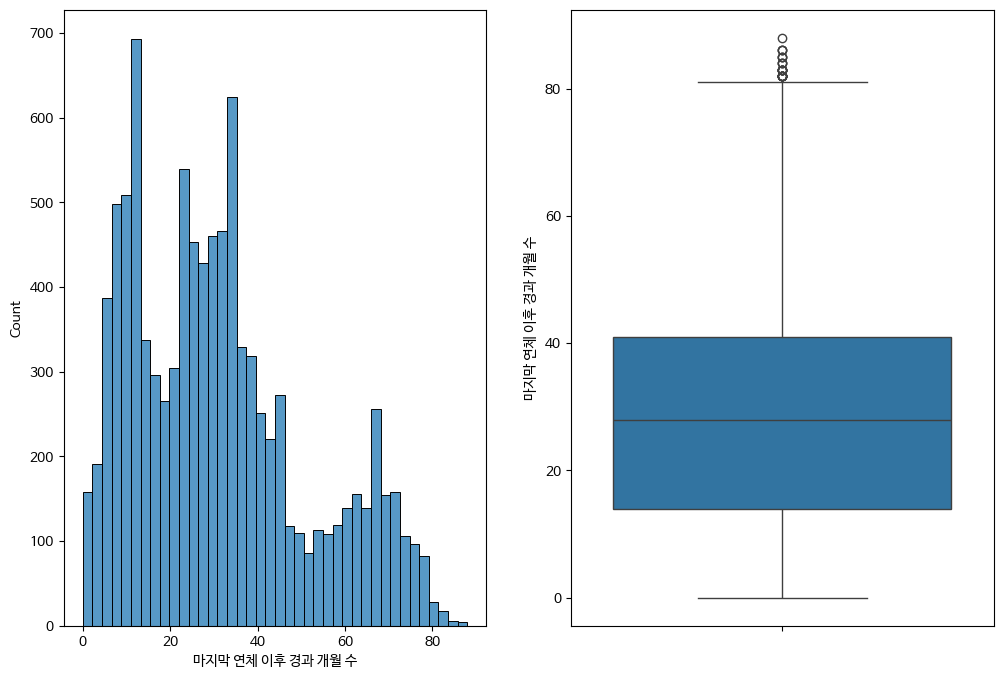

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['마지막 연체 이후 경과 개월 수'], bins=40 ,ax=axes[0])
sns.boxplot(train['마지막 연체 이후 경과 개월 수'], ax=axes[1])

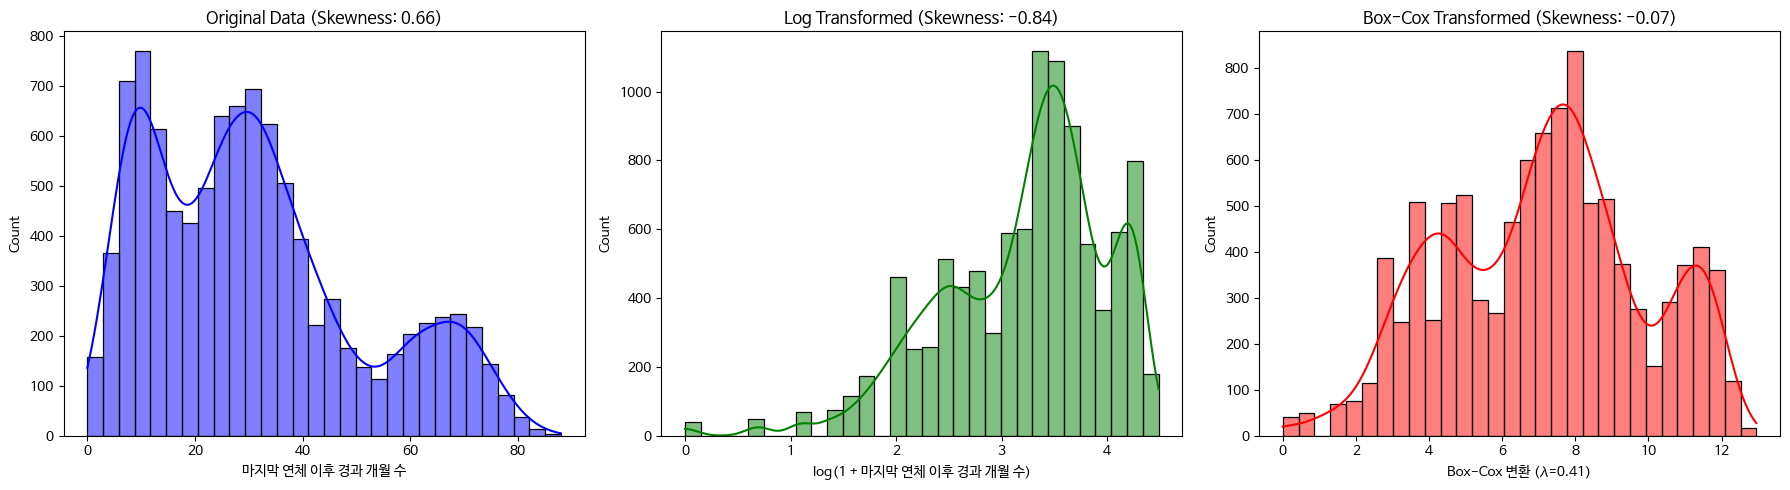

원본 데이터 왜도: 0.66
로그 변환 후 왜도: -0.84
Box-Cox 변환 후 왜도: -0.07 (λ=0.41)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, boxcox

# 데이터 복사 (결측값 제거)
data = train['마지막 연체 이후 경과 개월 수'].dropna()

# 1. 원본 데이터 왜도 계산
original_skew = skew(data)

# 2. 로그 변환 (0 이상인 값만 사용해야 함)
log_data = np.log1p(data)  # log(1 + x) 변환
log_skew = skew(log_data)

# 3. Box-Cox 변환 (양수 데이터만 가능, 0 이상 필터링)
boxcox_data, lambda_val = boxcox(data + 1)  # 0을 방지하기 위해 +1
boxcox_skew = skew(boxcox_data)

# 4. 히스토그램 & 왜도 비교 (2×2 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본 데이터
sns.histplot(data, kde=True, bins=30, color='blue', ax=axes[0])
axes[0].set_title(f"Original Data (Skewness: {original_skew:.2f})")
axes[0].set_xlabel("마지막 연체 이후 경과 개월 수")

# 로그 변환 데이터
sns.histplot(log_data, kde=True, bins=30, color='green', ax=axes[1])
axes[1].set_title(f"Log Transformed (Skewness: {log_skew:.2f})")
axes[1].set_xlabel("log(1 + 마지막 연체 이후 경과 개월 수)")

# Box-Cox 변환 데이터
sns.histplot(boxcox_data, kde=True, bins=30, color='red', ax=axes[2])
axes[2].set_title(f"Box-Cox Transformed (Skewness: {boxcox_skew:.2f})")
axes[2].set_xlabel(f"Box-Cox 변환 (λ={lambda_val:.2f})")

plt.tight_layout()
plt.show()

# 왜도 출력
print(f"원본 데이터 왜도: {original_skew:.2f}")
print(f"로그 변환 후 왜도: {log_skew:.2f}")
print(f"Box-Cox 변환 후 왜도: {boxcox_skew:.2f} (λ={lambda_val:.2f})")


In [ ]:
from scipy.stats import boxcox

# Box-Cox 변환을 적용
train['마지막 연체 이후 경과 개월 수'] = boxcox(train['마지막 연체 이후 경과 개월 수']+1)[0]
test['마지막 연체 이후 경과 개월 수'] = boxcox(test['마지막 연체 이후 경과 개월 수']+1)[0]

## 개인 파산 횟수

count    10000.000000
mean         0.373200
std          0.843797
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: 개인 파산 횟수, dtype: float64


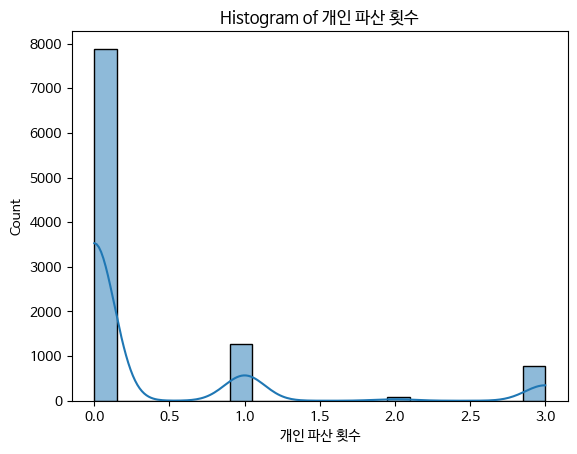

In [ ]:
# 기본 통계량 확인
print(train['개인 파산 횟수'].describe())

# 분포 확인 (히스토그램)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['개인 파산 횟수'], kde=True, bins=20)
plt.title('Histogram of 개인 파산 횟수')
plt.show()

In [ ]:
import pandas as pd

# '개인 파산 횟수' 값별 개수 및 비율 계산
train_bankruptcy_counts = train['개인 파산 횟수'].value_counts()
train_bankruptcy_percentage = train['개인 파산 횟수'].value_counts(normalize=True) * 100  # 비율 계산

# '개인 파산 횟수' 비교 DataFrame
bankruptcy_comparison_df = pd.DataFrame({
    'Train Count': train_bankruptcy_counts,
    'Train Percentage': train_bankruptcy_percentage,
}).fillna(0)  # NaN 값은 0으로 채움

print("\n[개인 파산 횟수] Train 데이터셋 (개수 및 비율):")
print(bankruptcy_comparison_df)


[개인 파산 횟수] Train 데이터셋 (개수 및 비율):
          Train Count  Train Percentage
개인 파산 횟수                               
0                7886             78.86
1                1268             12.68
3                 772              7.72
2                  74              0.74


In [ ]:
# 추후 삭제 예정 (test 데이터 사용)
'''
import pandas as pd

# '개인 파산 횟수' 값별 개수 및 비율 계산
train_bankruptcy_counts = train['개인 파산 횟수'].value_counts()
train_bankruptcy_percentage = train['개인 파산 횟수'].value_counts(normalize=True) * 100  # 비율 계산

test_bankruptcy_counts = test['개인 파산 횟수'].value_counts()
test_bankruptcy_percentage = test['개인 파산 횟수'].value_counts(normalize=True) * 100  # 비율 계산

# '개인 파산 횟수' 비교 DataFrame
bankruptcy_comparison_df = pd.DataFrame({
    'Train Count': train_bankruptcy_counts,
    'Train Percentage': train_bankruptcy_percentage,
    'Test Count': test_bankruptcy_counts,
    'Test Percentage': test_bankruptcy_percentage
}).fillna(0)  # NaN 값은 0으로 채움

print("\n[개인 파산 횟수] Train과 Test 데이터셋 비교 (개수 및 비율):")
print(bankruptcy_comparison_df)
'''

'\nimport pandas as pd\n\n# \'개인 파산 횟수\' 값별 개수 및 비율 계산\ntrain_bankruptcy_counts = train[\'개인 파산 횟수\'].value_counts()\ntrain_bankruptcy_percentage = train[\'개인 파산 횟수\'].value_counts(normalize=True) * 100  # 비율 계산\n\ntest_bankruptcy_counts = test[\'개인 파산 횟수\'].value_counts()\ntest_bankruptcy_percentage = test[\'개인 파산 횟수\'].value_counts(normalize=True) * 100  # 비율 계산\n\n# \'개인 파산 횟수\' 비교 DataFrame\nbankruptcy_comparison_df = pd.DataFrame({\n    \'Train Count\': train_bankruptcy_counts,\n    \'Train Percentage\': train_bankruptcy_percentage,\n    \'Test Count\': test_bankruptcy_counts,\n    \'Test Percentage\': test_bankruptcy_percentage\n}).fillna(0)  # NaN 값은 0으로 채움\n\nprint("\n[개인 파산 횟수] Train과 Test 데이터셋 비교 (개수 및 비율):")\nprint(bankruptcy_comparison_df)\n'

-> 이상치 제거 및 전처리 진행 x

## 대출 목적

count     10000
unique       14
top       부채 통합
freq       7294
Name: 대출 목적, dtype: object


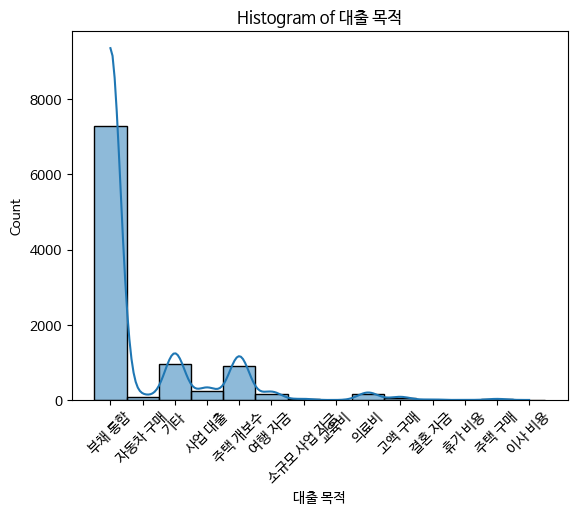

In [ ]:
# 기본 통계량 확인
print(train['대출 목적'].describe())

# 분포 확인 (히스토그램)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['대출 목적'], kde=True, bins=20)
plt.title('Histogram of 대출 목적')

# x축과 y축 글씨 기울이기
plt.xticks(rotation=45)

plt.show()

In [ ]:
# train 데이터셋의 '대출 목적' 값별 개수와 비율 계산
train_value_counts = train['대출 목적'].value_counts()
train_value_counts_percentage = train['대출 목적'].value_counts(normalize=True) * 100  # 비율 계산

# 데이터프레임 생성 (값, 개수, 비율)
comparison_df = pd.DataFrame({
    'Train Count': train_value_counts,
    'Train Percentage': train_value_counts_percentage,
}).fillna(0)  # NaN 값은 0으로 채워서 비교

print("\nTrain 데이터셋 - 대출 목적 (개수 및 비율):")
print(comparison_df)


Train 데이터셋 - 대출 목적 (개수 및 비율):
           Train Count  Train Percentage
대출 목적                                   
부채 통합             7294             72.94
기타                 970              9.70
주택 개보수             909              9.09
사업 대출              254              2.54
여행 자금              173              1.73
의료비                158              1.58
자동차 구매              95              0.95
고액 구매               68              0.68
소규모 사업 자금           26              0.26
주택 구매               26              0.26
결혼 자금               14              0.14
휴가 비용                6              0.06
이사 비용                4              0.04
교육비                  3              0.03


In [ ]:
# 추후 삭제 예정 (test 데이터 사용)
'''
# train 데이터셋의 '대출 목적' 값별 개수와 비율 계산
train_value_counts = train['대출 목적'].value_counts()
train_value_counts_percentage = train['대출 목적'].value_counts(normalize=True) * 100  # 비율 계산

# test 데이터셋의 '대출 목적' 값별 개수와 비율 계산
test_value_counts = test['대출 목적'].value_counts()
test_value_counts_percentage = test['대출 목적'].value_counts(normalize=True) * 100  # 비율 계산

# 데이터프레임 생성 (값, 개수, 비율)
comparison_df = pd.DataFrame({
    'Train Count': train_value_counts,
    'Train Percentage': train_value_counts_percentage,
    'Test Count': test_value_counts,
    'Test Percentage': test_value_counts_percentage
}).fillna(0)  # NaN 값은 0으로 채워서 비교

print("\nTrain과 Test 데이터셋 비교 (개수 및 비율):")
print(comparison_df)
'''

'\n# train 데이터셋의 \'대출 목적\' 값별 개수와 비율 계산\ntrain_value_counts = train[\'대출 목적\'].value_counts()\ntrain_value_counts_percentage = train[\'대출 목적\'].value_counts(normalize=True) * 100  # 비율 계산\n\n# test 데이터셋의 \'대출 목적\' 값별 개수와 비율 계산\ntest_value_counts = test[\'대출 목적\'].value_counts()\ntest_value_counts_percentage = test[\'대출 목적\'].value_counts(normalize=True) * 100  # 비율 계산\n\n# 데이터프레임 생성 (값, 개수, 비율)\ncomparison_df = pd.DataFrame({\n    \'Train Count\': train_value_counts,\n    \'Train Percentage\': train_value_counts_percentage,\n    \'Test Count\': test_value_counts,\n    \'Test Percentage\': test_value_counts_percentage\n}).fillna(0)  # NaN 값은 0으로 채워서 비교\n\nprint("\nTrain과 Test 데이터셋 비교 (개수 및 비율):")\nprint(comparison_df)\n'

이상치 제거 및 변환 진행 x

## 대출 상환 기간

count     10000
unique        2
top       단기 상환
freq       6975
Name: 대출 상환 기간, dtype: object


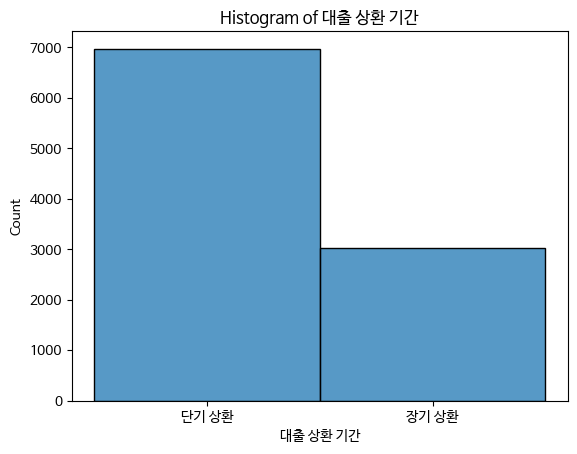

In [ ]:
# 기본 통계량 확인
print(train['대출 상환 기간'].describe())

# 분포 확인 (히스토그램)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['대출 상환 기간'], kde=False, bins=20)
plt.title('Histogram of 대출 상환 기간')

plt.show()

In [ ]:
# train 데이터셋의 '대출 상환 기간' 값별 개수와 비율 계산
train_value_counts = train['대출 상환 기간'].value_counts()
train_value_counts_percentage = train['대출 상환 기간'].value_counts(normalize=True) * 100  # 비율 계산

# 데이터프레임 생성 (값, 개수, 비율)
comparison_df = pd.DataFrame({
    'Train Count': train_value_counts,
    'Train Percentage': train_value_counts_percentage,
}).fillna(0)  # NaN 값은 0으로 채워서 비교

print("\nTrain 데이터셋 (개수 및 비율):")
print(comparison_df)


Train 데이터셋 (개수 및 비율):
          Train Count  Train Percentage
대출 상환 기간                               
단기 상환            6975             69.75
장기 상환            3025             30.25


In [ ]:
# 추후 삭제 예정 (test 데이터 사용)
'''
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. train과 test의 '장기'와 '단기' 개수 및 비율 비교
train_counts = train['대출 상환 기간'].value_counts()
test_counts = test['대출 상환 기간'].value_counts()

train_ratios = train_counts / train_counts.sum()
test_ratios = test_counts / test_counts.sum()

# 비교 데이터프레임 생성
compare_df = pd.DataFrame({
    'Train Count': train_counts,
    'Test Count': test_counts,
    'Train Ratio': train_ratios,
    'Test Ratio': test_ratios
})

print(compare_df)

# 2×2 서브플롯 구성
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 그래프 스타일
colors = ["#4C72B0", "#DD8452"]  # Train: 파란색, Test: 주황색

# 1. Train Count
sns.barplot(x=compare_df.index, y=compare_df['Train Count'], color=colors[0], ax=axes[0, 0])
axes[0, 0].set_title('Train Count')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(compare_df['Train Count']):
    axes[0, 0].text(i, v + 1, str(v), ha='center', fontsize=12)  # 값 표시

# 2. Test Count
sns.barplot(x=compare_df.index, y=compare_df['Test Count'], color=colors[1], ax=axes[0, 1])
axes[0, 1].set_title('Test Count')
axes[0, 1].set_ylabel('Count')
for i, v in enumerate(compare_df['Test Count']):
    axes[0, 1].text(i, v + 1, str(v), ha='center', fontsize=12)  # 값 표시

# 3. Train Ratio
sns.barplot(x=compare_df.index, y=compare_df['Train Ratio'], color=colors[0], ax=axes[1, 0])
axes[1, 0].set_title('Train Ratio')
axes[1, 0].set_ylabel('Ratio')
for i, v in enumerate(compare_df['Train Ratio']):
    axes[1, 0].text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=12)  # 백분율 표시

# 4. Test Ratio
sns.barplot(x=compare_df.index, y=compare_df['Test Ratio'], color=colors[1], ax=axes[1, 1])
axes[1, 1].set_title('Test Ratio')
axes[1, 1].set_ylabel('Ratio')
for i, v in enumerate(compare_df['Test Ratio']):
    axes[1, 1].text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=12)  # 백분율 표시

# 그래프 간 간격 조정
plt.tight_layout()
plt.show()
'''

'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# 1. train과 test의 \'장기\'와 \'단기\' 개수 및 비율 비교\ntrain_counts = train[\'대출 상환 기간\'].value_counts()\ntest_counts = test[\'대출 상환 기간\'].value_counts()\n\ntrain_ratios = train_counts / train_counts.sum()\ntest_ratios = test_counts / test_counts.sum()\n\n# 비교 데이터프레임 생성\ncompare_df = pd.DataFrame({\n    \'Train Count\': train_counts,\n    \'Test Count\': test_counts,\n    \'Train Ratio\': train_ratios,\n    \'Test Ratio\': test_ratios\n})\n\nprint(compare_df)\n\n# 2×2 서브플롯 구성\nfig, axes = plt.subplots(2, 2, figsize=(12, 10))\n\n# 그래프 스타일\ncolors = ["#4C72B0", "#DD8452"]  # Train: 파란색, Test: 주황색\n\n# 1. Train Count\nsns.barplot(x=compare_df.index, y=compare_df[\'Train Count\'], color=colors[0], ax=axes[0, 0])\naxes[0, 0].set_title(\'Train Count\')\naxes[0, 0].set_ylabel(\'Count\')\nfor i, v in enumerate(compare_df[\'Train Count\']):\n    axes[0, 0].text(i, v + 1, str(v), ha=\'center\', fontsize=12)  # 값 표시\n\n# 2. T

train, test의 비율이 비슷함
=> 이상치 제거 및 변환 진행 x

## DSR  (월 소득 대비 월 상환액 비율 Debt Service Ratio)

In [ ]:
train['DSR'].isnull().sum()

0

In [ ]:
# 추후 삭제 예정 (test 데이터 사용)
''''
# 그래프 사이즈 설정
plt.figure(figsize=(12, 5))

# Train 데이터 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(y=train['DSR'])
plt.title('Train - DSR')

# Test 데이터 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(y=test['DSR'])
plt.title('Test - DSR')

plt.show()
'''

"'\n# 그래프 사이즈 설정\nplt.figure(figsize=(12, 5))\n\n# Train 데이터 박스플롯\nplt.subplot(1, 2, 1)\nsns.boxplot(y=train['DSR'])\nplt.title('Train - DSR')\n\n# Test 데이터 박스플롯\nplt.subplot(1, 2, 2)\nsns.boxplot(y=test['DSR'])\nplt.title('Test - DSR')\n\nplt.show()\n"

<Axes: ylabel='DSR'>

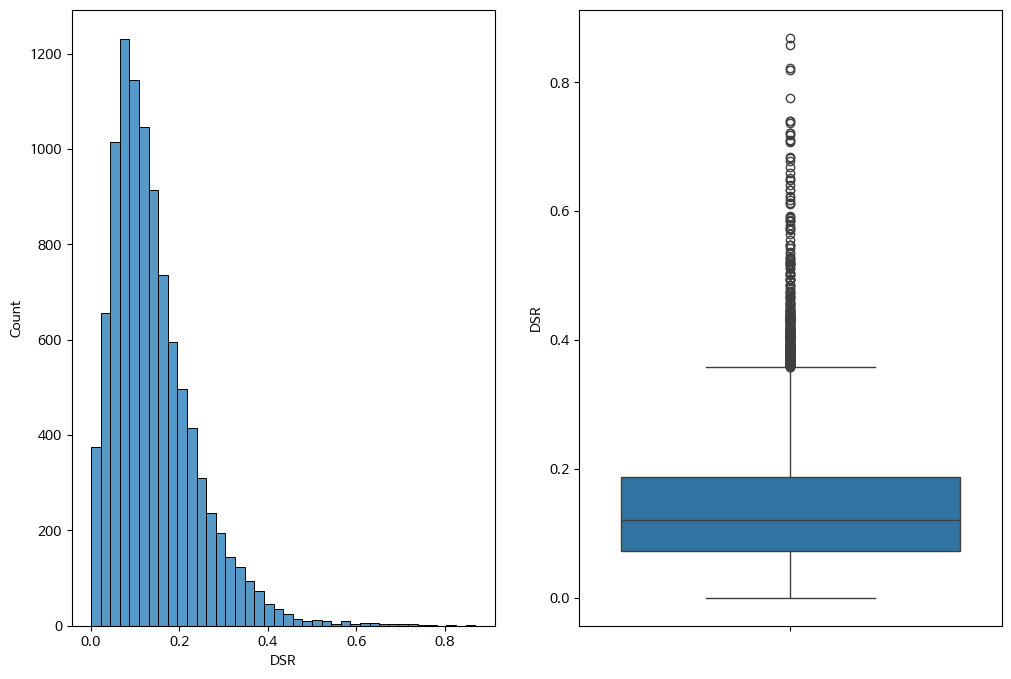

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['DSR'], bins=40 ,ax=axes[0])
sns.boxplot(train['DSR'], ax=axes[1])

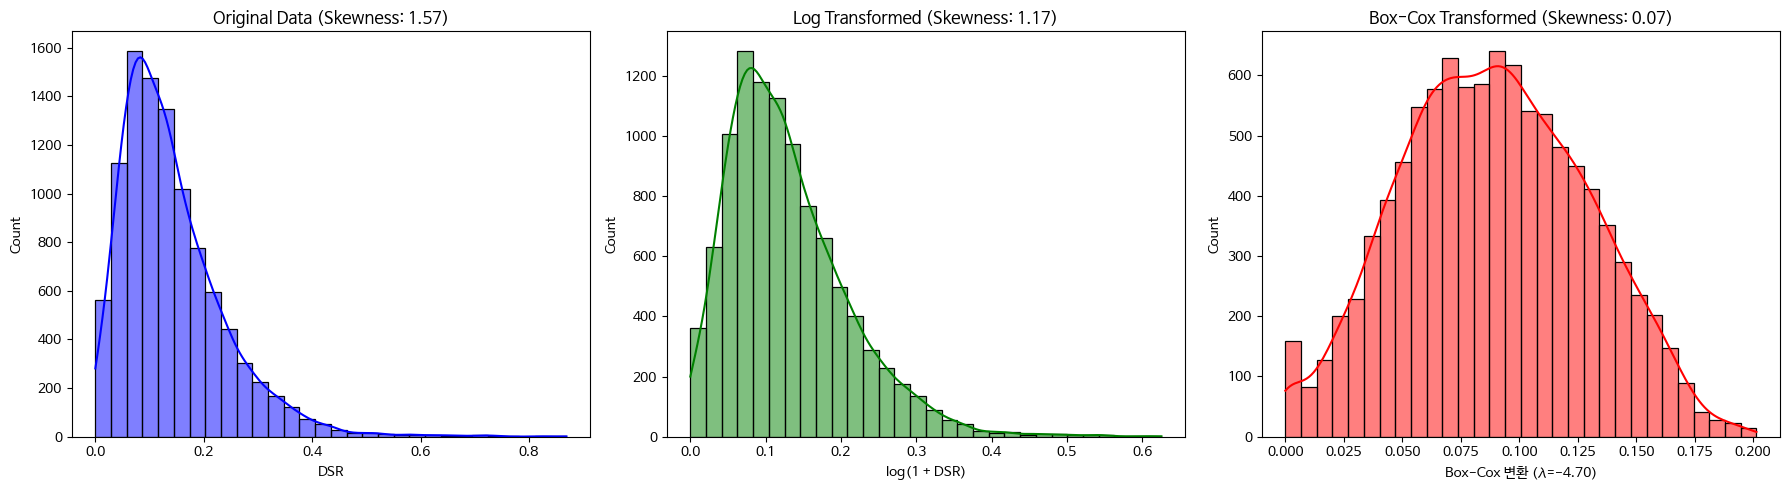

원본 데이터 왜도: 1.57
로그 변환 후 왜도: 1.17
Box-Cox 변환 후 왜도: 0.07 (λ=-4.70)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, boxcox

# 데이터 복사 (결측값 제거)
data = train['DSR'].dropna()

# 1. 원본 데이터 왜도 계산
original_skew = skew(data)

# 2. 로그 변환 (0 이상인 값만 사용해야 함)
log_data = np.log1p(data)  # log(1 + x) 변환
log_skew = skew(log_data)

# 3. Box-Cox 변환 (양수 데이터만 가능, 0 이상 필터링)
boxcox_data, lambda_val = boxcox(data + 1)  # 0을 방지하기 위해 +1
boxcox_skew = skew(boxcox_data)

# 4. 히스토그램 & 왜도 비교 (2×2 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본 데이터
sns.histplot(data, kde=True, bins=30, color='blue', ax=axes[0])
axes[0].set_title(f"Original Data (Skewness: {original_skew:.2f})")
axes[0].set_xlabel("DSR")

# 로그 변환 데이터
sns.histplot(log_data, kde=True, bins=30, color='green', ax=axes[1])
axes[1].set_title(f"Log Transformed (Skewness: {log_skew:.2f})")
axes[1].set_xlabel("log(1 + DSR)")

# Box-Cox 변환 데이터
sns.histplot(boxcox_data, kde=True, bins=30, color='red', ax=axes[2])
axes[2].set_title(f"Box-Cox Transformed (Skewness: {boxcox_skew:.2f})")
axes[2].set_xlabel(f"Box-Cox 변환 (λ={lambda_val:.2f})")

plt.tight_layout()
plt.show()

# 왜도 출력
print(f"원본 데이터 왜도: {original_skew:.2f}")
print(f"로그 변환 후 왜도: {log_skew:.2f}")
print(f"Box-Cox 변환 후 왜도: {boxcox_skew:.2f} (λ={lambda_val:.2f})")


In [ ]:
### BOX COX 변환 적용

from scipy.stats import boxcox

# Box-Cox 변환을 적용
train['DSR'] = boxcox(train['DSR']+1)[0]
test['DSR'] = boxcox(test['DSR']+1)[0]

## 신용카드 사용 집중도

In [ ]:
train['신용카드 사용 집중도'].isnull().sum()

0

In [ ]:
# 추후 삭제 예정 (test 데이터 사용)
'''
# 그래프 사이즈 설정
plt.figure(figsize=(12, 5))

# Train 데이터 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(y=train['신용카드 사용 집중도'])
plt.title('Train - 신용카드 사용 집중도')

# Test 데이터 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(y=test['신용카드 사용 집중도'])
plt.title('Test - 신용카드 사용 집중도')

plt.show()
'''

"\n# 그래프 사이즈 설정\nplt.figure(figsize=(12, 5))\n\n# Train 데이터 박스플롯\nplt.subplot(1, 2, 1)\nsns.boxplot(y=train['신용카드 사용 집중도'])\nplt.title('Train - 신용카드 사용 집중도')\n\n# Test 데이터 박스플롯\nplt.subplot(1, 2, 2)\nsns.boxplot(y=test['신용카드 사용 집중도'])\nplt.title('Test - 신용카드 사용 집중도')\n\nplt.show()\n"

왜도 (Skewness): 0.1045


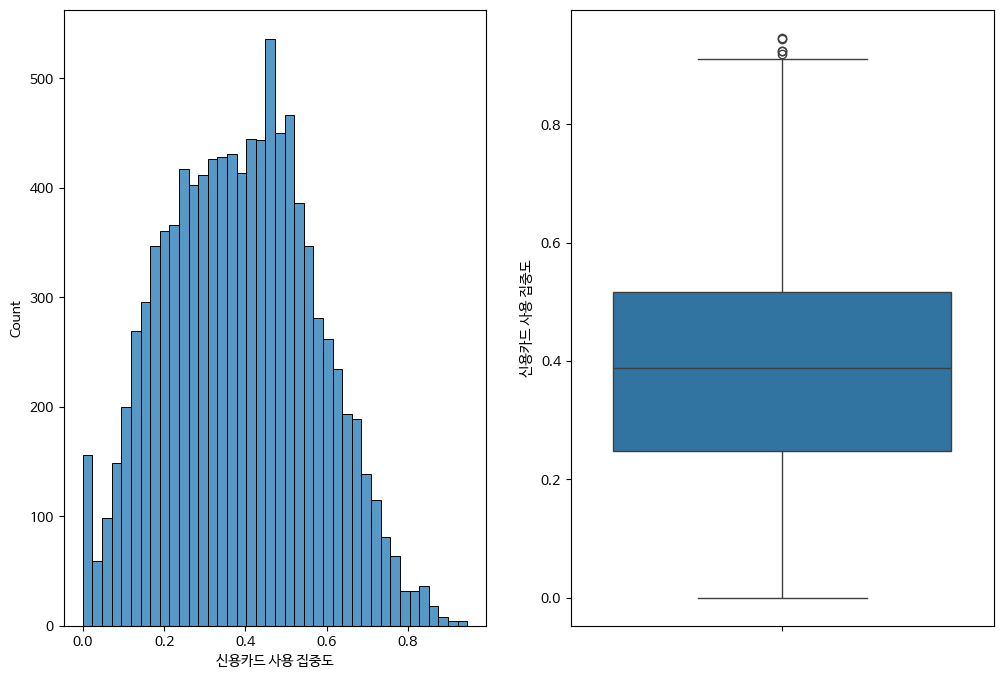

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['신용카드 사용 집중도'], bins=40 ,ax=axes[0])
sns.boxplot(train['신용카드 사용 집중도'], ax=axes[1])

skewness = skew(train['신용카드 사용 집중도'])
print(f"왜도 (Skewness): {skewness:.4f}")

-> 전처리 진행 및 변환 x

## 현재 대출 잔액

In [ ]:
train['현재 대출 잔액'].isnull().sum()

0

<Axes: ylabel='현재 대출 잔액'>

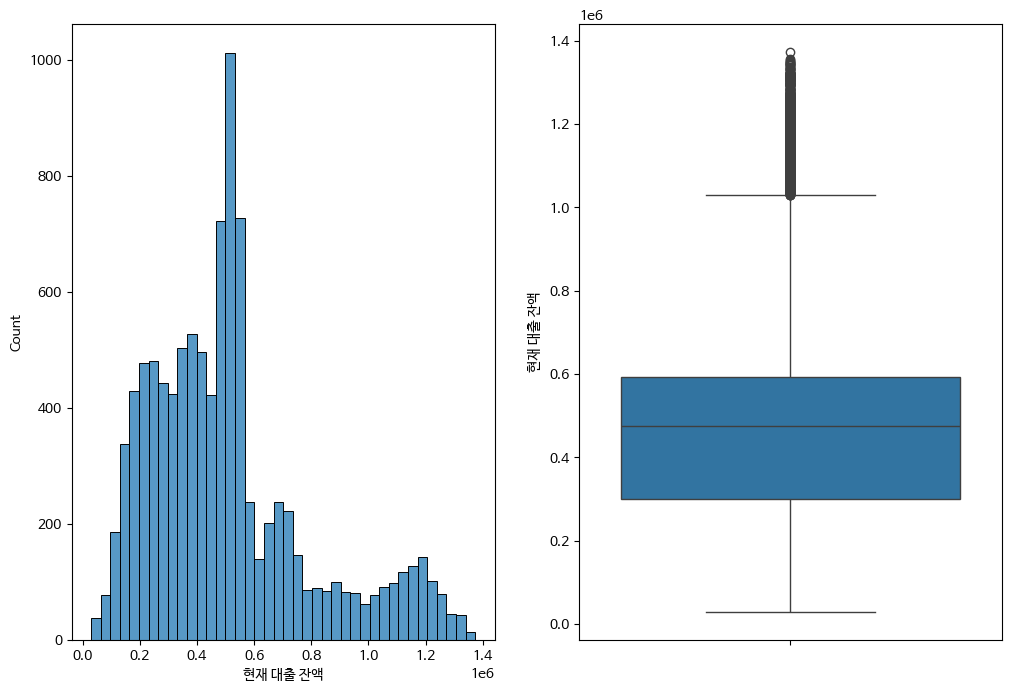

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['현재 대출 잔액'], bins=40 ,ax=axes[0])
sns.boxplot(train['현재 대출 잔액'], ax=axes[1])

## 현재 미상환 신용액

In [ ]:
train['현재 미상환 신용액'].isnull().sum()

0

<Axes: ylabel='현재 미상환 신용액'>

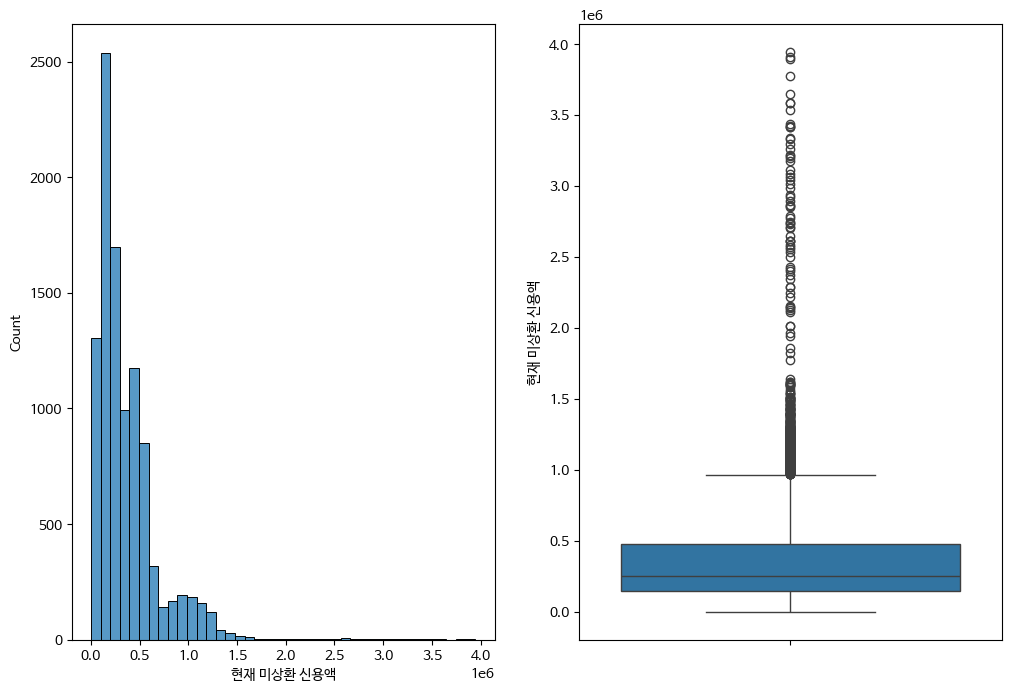

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['현재 미상환 신용액'], bins=40 ,ax=axes[0])
sns.boxplot(train['현재 미상환 신용액'], ax=axes[1])

## 월 상환 부채액

In [ ]:
train['월 상환 부채액'].isnull().sum()

0

<Axes: ylabel='월 상환 부채액'>

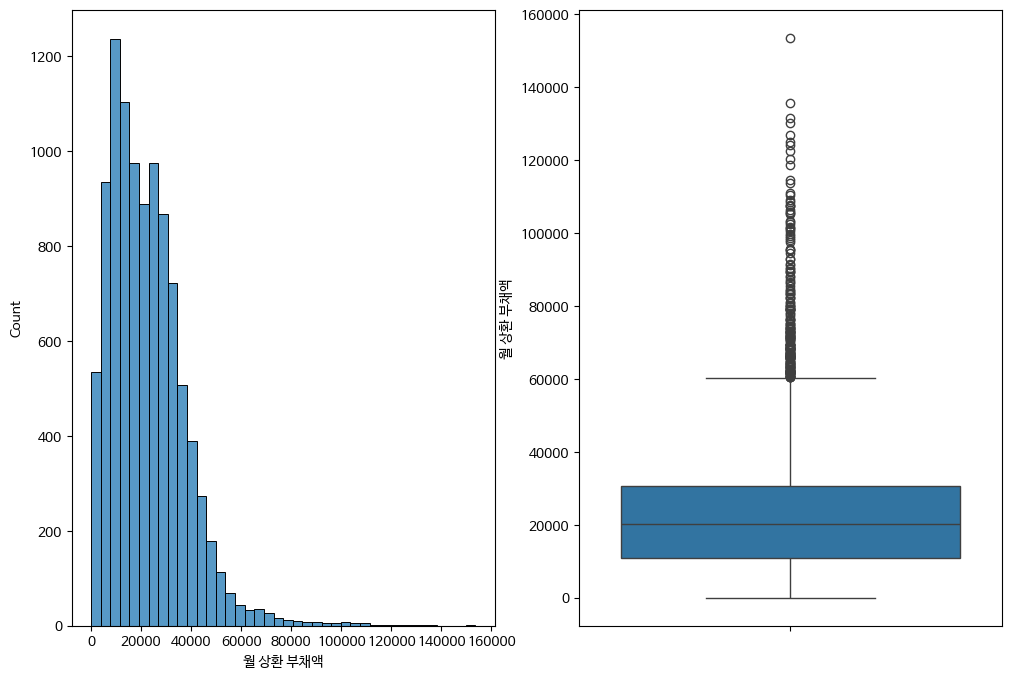

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['월 상환 부채액'], bins=40 ,ax=axes[0])
sns.boxplot(train['월 상환 부채액'], ax=axes[1])

## 신용 점수

In [ ]:
train['신용 점수'].isnull().sum()

0

In [ ]:
train[(train['신용 점수'] <= 300) & (train['신용 점수'] >= 900)]

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,...,DTI,대출 대 소득 비율,DSR,신용카드 사용 집중도,고위험 지표,신용 이벤트 발생 빈도,신규 계좌 개설 빈도,대출목적_연체율,1년 내 연체 여부,연체 경험 여부


<Axes: ylabel='신용 점수'>

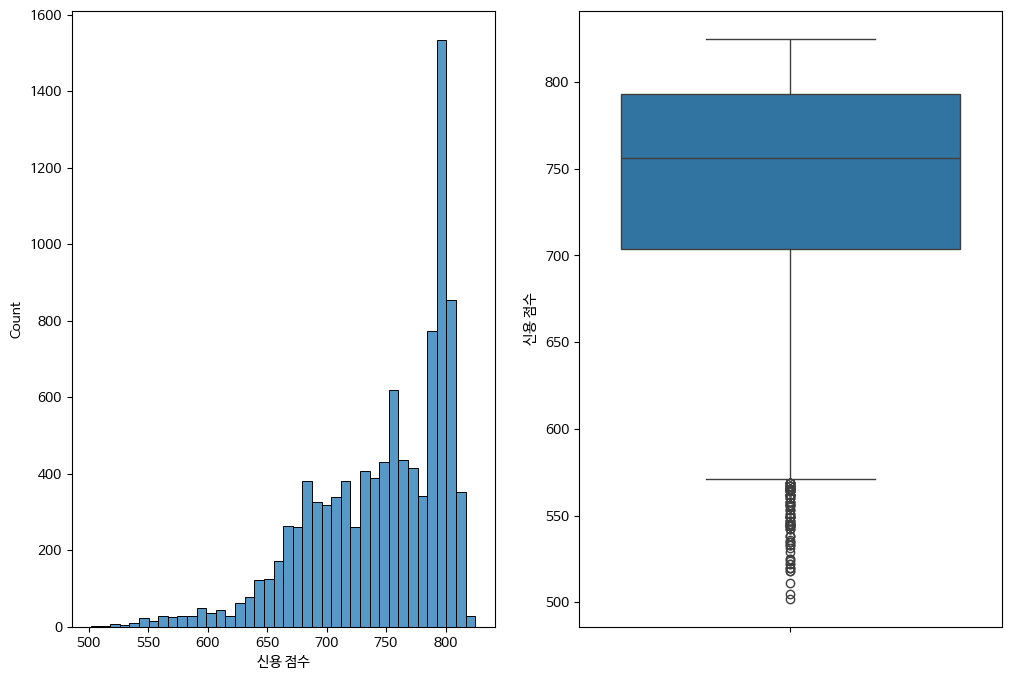

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['신용 점수'], bins=40 ,ax=axes[0])
sns.boxplot(train['신용 점수'], ax=axes[1])

4가지 변수 모두 결측치가 없고 연속형 변수이므로 Box-Cox 변환 진행

신용 점수의 경우 신용 등급으로 범주화하려고 하였으나 검색해보니 원래 신용등급제에서 2021년에 신용점수제로 변경된 것을 확인하여 범주화를 진행하지 않고 원래대로 사용하기로 결정

## 로그 변환 ("현재 대출 잔액","현재 미상환 신용액", "월 상환 부채액", "신용 점수")

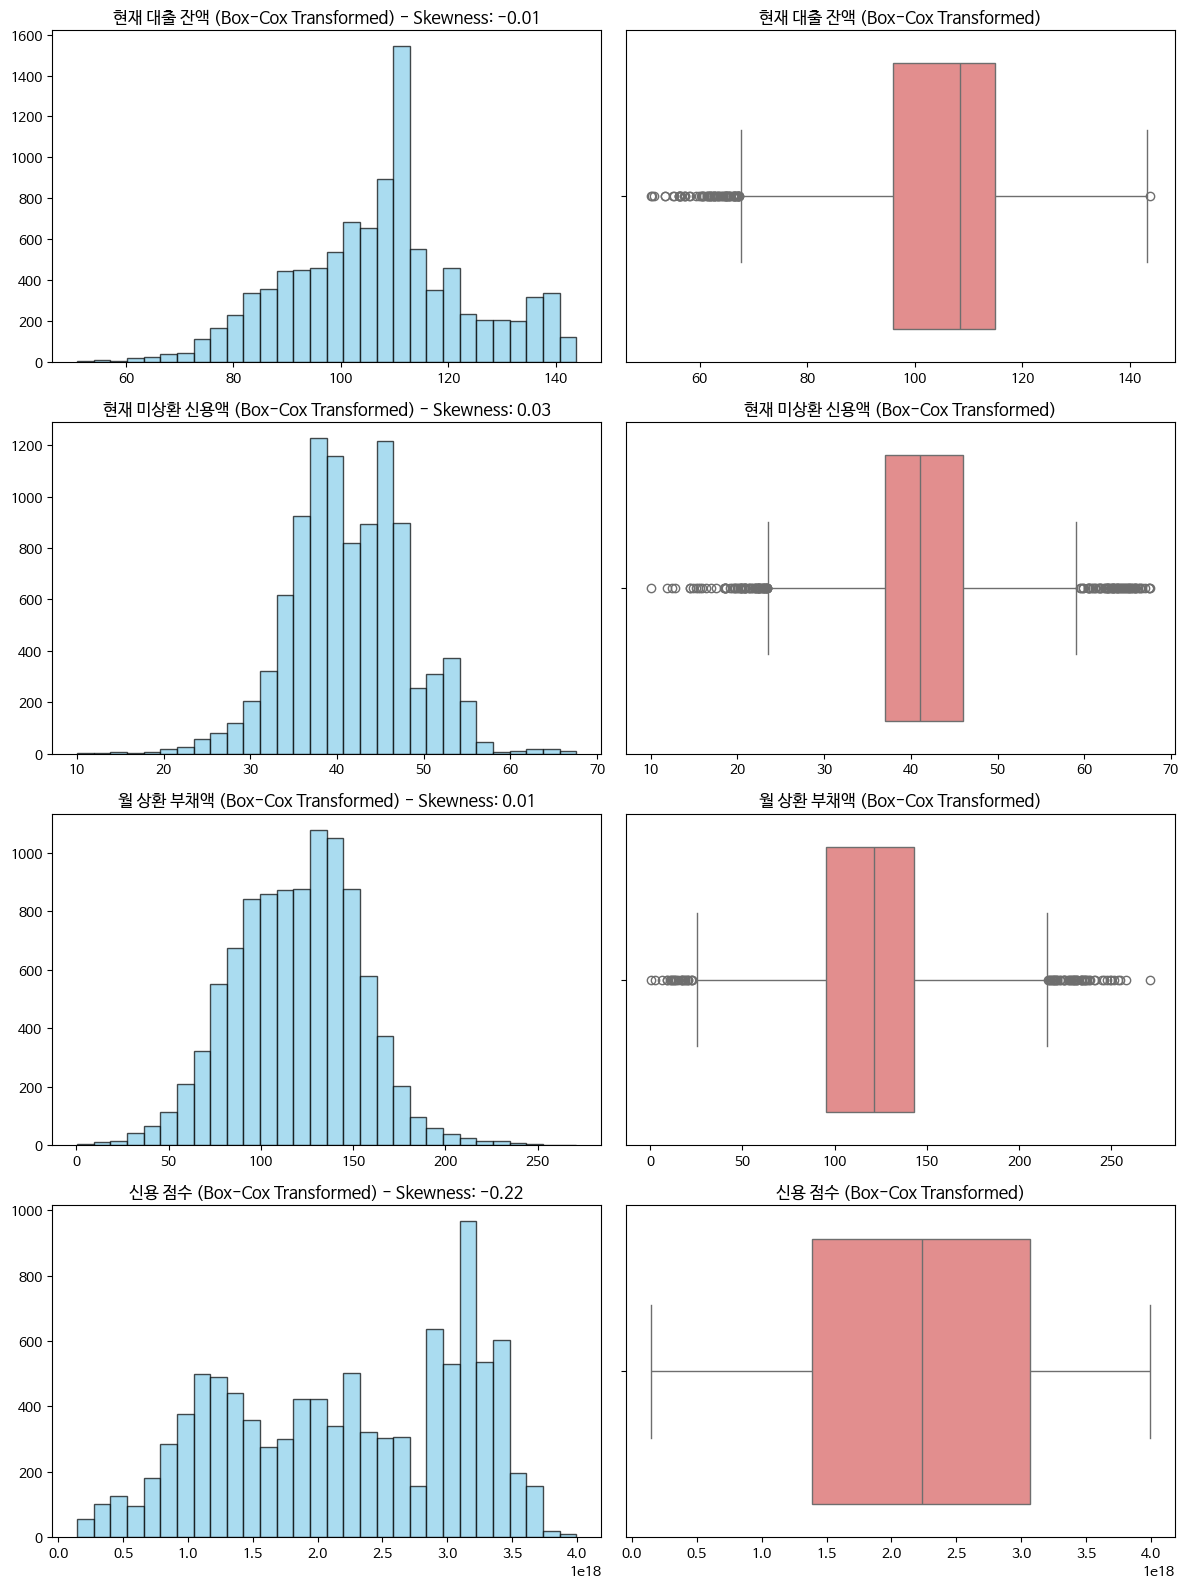

In [ ]:
import scipy.stats as stats

# Box-Cox 변환이 가능한 수치형 컬럼 선택
numeric_cols = ["현재 대출 잔액","현재 미상환 신용액", "월 상환 부채액", "신용 점수"]

# 시각화 설정
plt.figure(figsize=(12, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    # 양수 값만 필터링 (Box-Cox 변환은 음수/0 값 불가능)
    positive_values = train[col][train[col] > 0]

    if len(positive_values) > 0:
        # Box-Cox 변환 수행
        transformed_data, lambda_ = stats.boxcox(positive_values)

        # 변환된 값을 train에 반영 (양수 값만 변환 후 대체)
        train.loc[train[col] > 0, col] = transformed_data

        # 왜도 계산
        skewness = stats.skew(transformed_data)

        # 시각화 (히스토그램 & 박스플롯)
        plt.subplot(len(numeric_cols), 2, 2 * i - 1)
        plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} (Box-Cox Transformed) - Skewness: {skewness:.2f}")

        plt.subplot(len(numeric_cols), 2, 2 * i)
        sns.boxplot(x=transformed_data, color='lightcoral')
        plt.title(f"{col} (Box-Cox Transformed)")

plt.tight_layout()
plt.show()

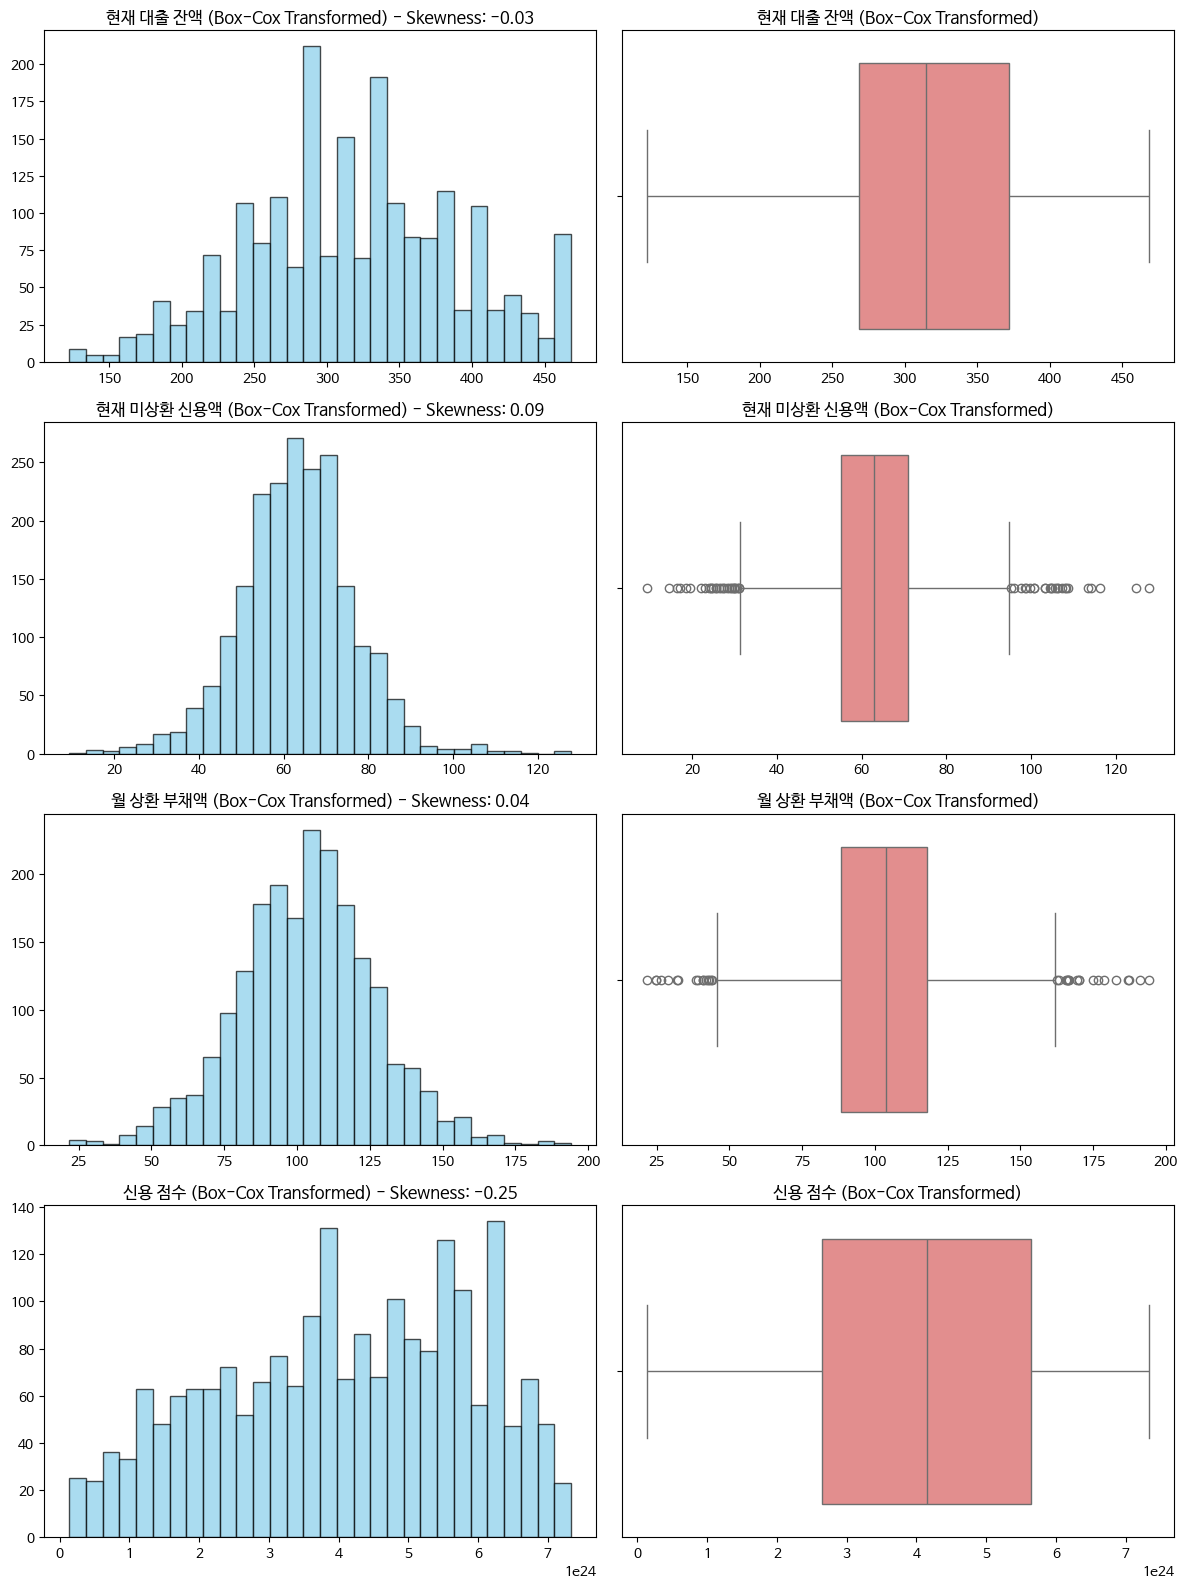

In [ ]:
### test 데이터에 대해서도 동일하게 진행
import scipy.stats as stats

# Box-Cox 변환이 가능한 수치형 컬럼 선택
numeric_cols = [
    "현재 대출 잔액","현재 미상환 신용액", "월 상환 부채액", "신용 점수"
]

# 변환된 데이터를 저장할 딕셔너리
boxcox_transformed = {}

# 시각화 설정
plt.figure(figsize=(12, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    # 양수 값만 필터링 (Box-Cox 변환은 음수/0 값 불가능)
    positive_values = test[col][test[col] > 0]

    if len(positive_values) > 0:
        # Box-Cox 변환 수행
        transformed_data, lambda_ = stats.boxcox(positive_values)

        # 변환된 데이터 저장
        boxcox_transformed[col] = transformed_data

        # 왜도 계산
        skewness = stats.skew(transformed_data)

        # 시각화 (히스토그램 & 박스플롯)
        plt.subplot(len(numeric_cols), 2, 2 * i - 1)
        plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} (Box-Cox Transformed) - Skewness: {skewness:.2f}")

        plt.subplot(len(numeric_cols), 2, 2 * i)
        sns.boxplot(x=transformed_data, color='lightcoral')
        plt.title(f"{col} (Box-Cox Transformed)")

plt.tight_layout()
plt.show()

## 총부채

In [ ]:
train['총 부채'].isnull().sum()

0

<Axes: ylabel='총 부채'>

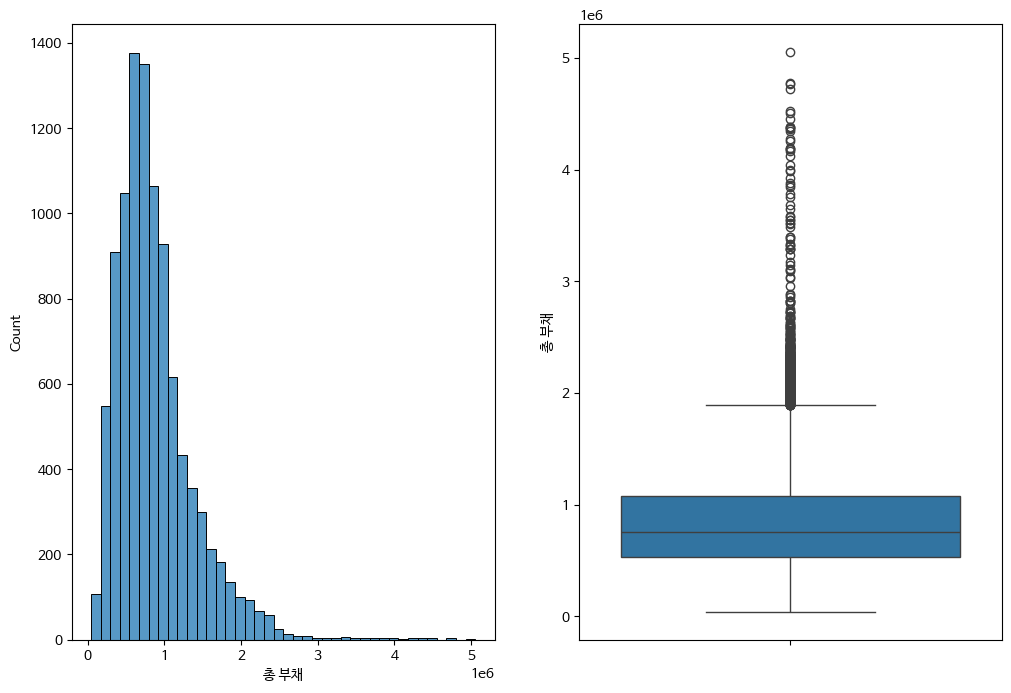

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['총 부채'], bins=40 ,ax=axes[0])
sns.boxplot(train['총 부채'], ax=axes[1])

## 총 부채 비율

In [ ]:
train['총 부채 비율'].isnull().sum()

0

<Axes: ylabel='총 부채 비율'>

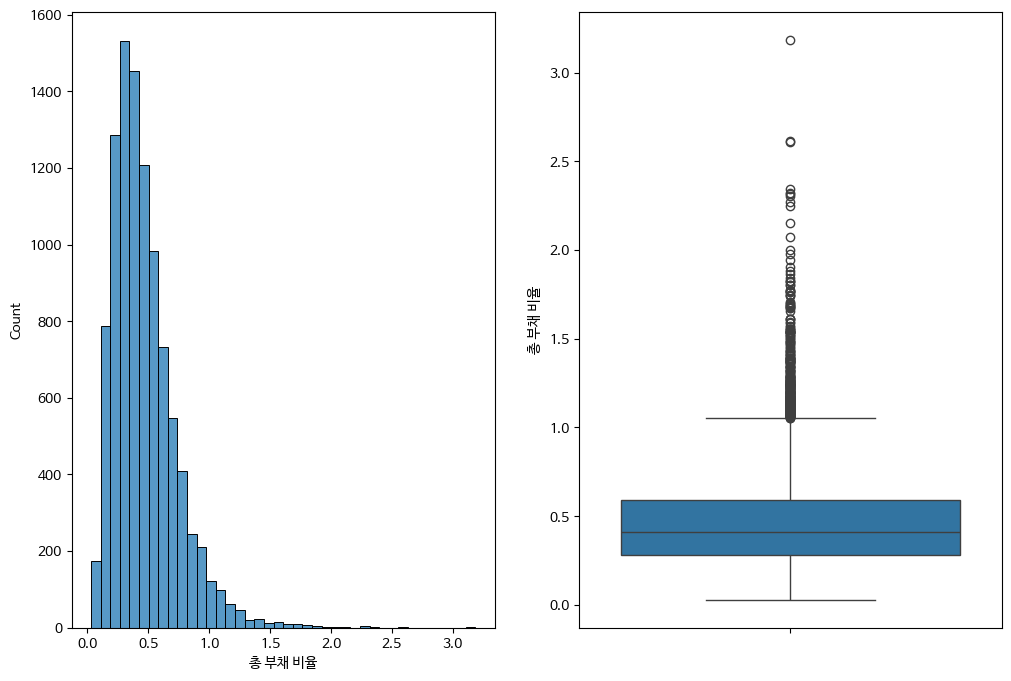

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['총 부채 비율'], bins=40 ,ax=axes[0])
sns.boxplot(train['총 부채 비율'], ax=axes[1])

## DTI

In [ ]:
train['DTI'].isnull().sum()

0

<Axes: ylabel='DTI'>

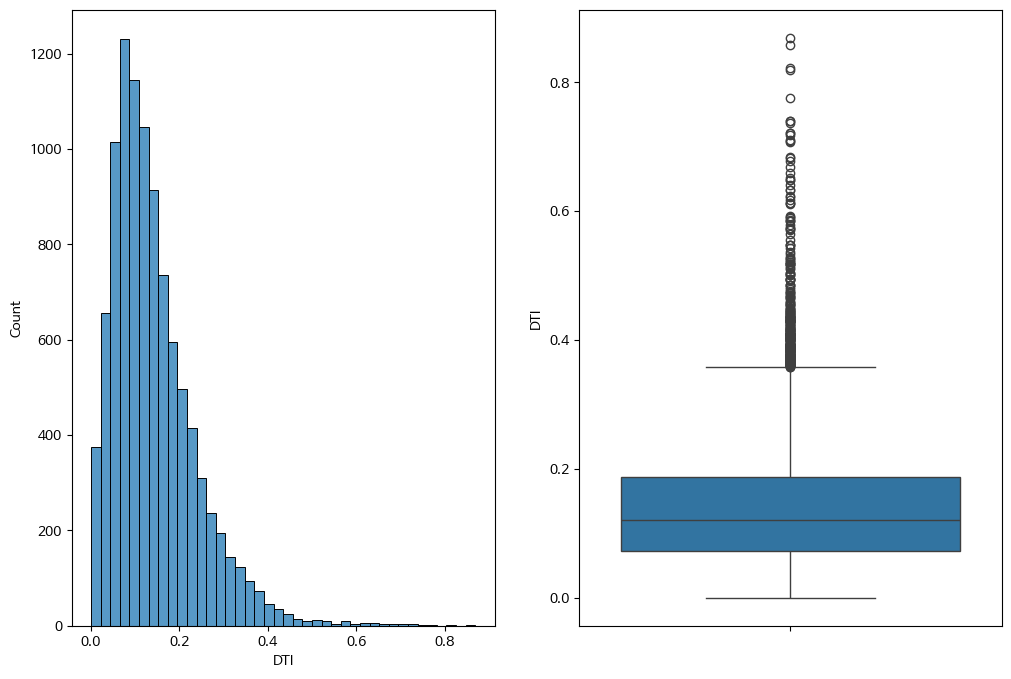

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['DTI'], bins=40 ,ax=axes[0])
sns.boxplot(train['DTI'], ax=axes[1])

## 대출 대 소득 비율

In [ ]:
train['대출 대 소득 비율'].isnull().sum()

0

<Axes: ylabel='대출 대 소득 비율'>

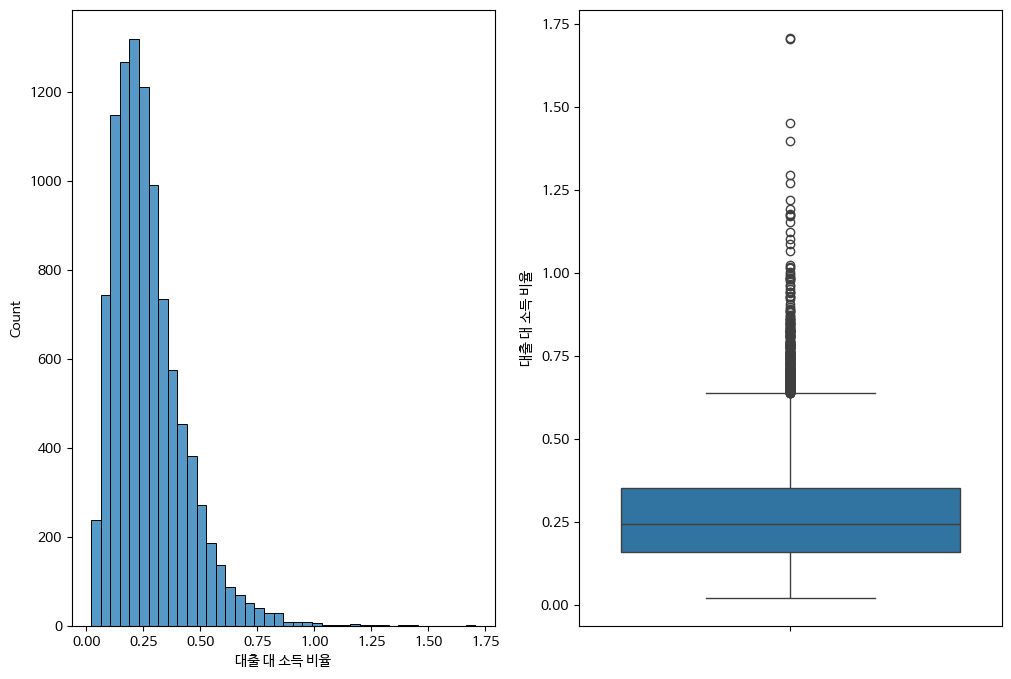

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
sns.histplot(train['대출 대 소득 비율'], bins=40 ,ax=axes[0])
sns.boxplot(train['대출 대 소득 비율'], ax=axes[1])

## 로그 변환 ("총 부채", "총 부채 비율", "DTI", "대출 대 소득 비율")

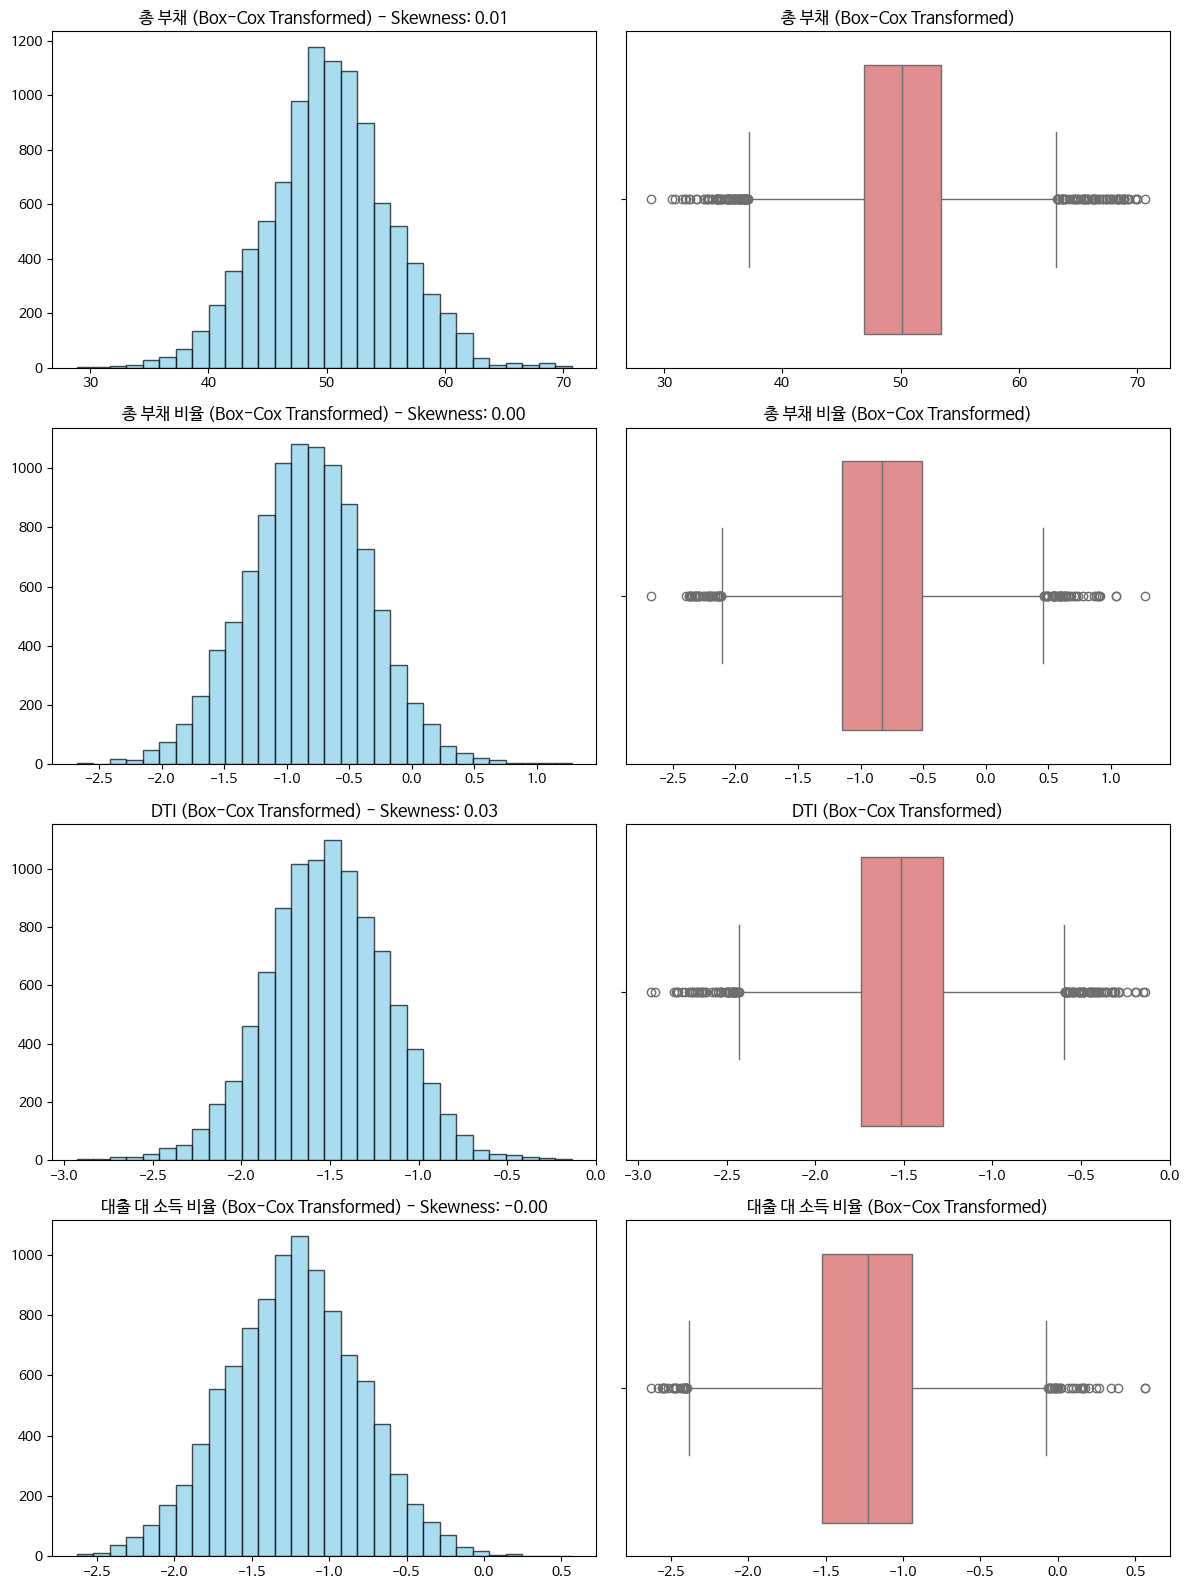

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Box-Cox 변환이 가능한 수치형 컬럼 선택
numeric_cols = ["총 부채", "총 부채 비율", "DTI", "대출 대 소득 비율"]

# 시각화 설정
plt.figure(figsize=(12, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    # 양수 값만 필터링 (Box-Cox 변환은 음수/0 값 불가능)
    positive_values = train[col][train[col] > 0]

    if len(positive_values) > 0:
        # Box-Cox 변환 수행
        transformed_data, lambda_ = stats.boxcox(positive_values)

        # 변환된 값을 train에 반영 (양수 값만 변환 후 대체)
        train.loc[train[col] > 0, col] = transformed_data

        # 왜도 계산
        skewness = stats.skew(transformed_data)

        # 시각화 (히스토그램 & 박스플롯)
        plt.subplot(len(numeric_cols), 2, 2 * i - 1)
        plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} (Box-Cox Transformed) - Skewness: {skewness:.2f}")

        plt.subplot(len(numeric_cols), 2, 2 * i)
        sns.boxplot(x=transformed_data, color='lightcoral')
        plt.title(f"{col} (Box-Cox Transformed)")

plt.tight_layout()
plt.show()

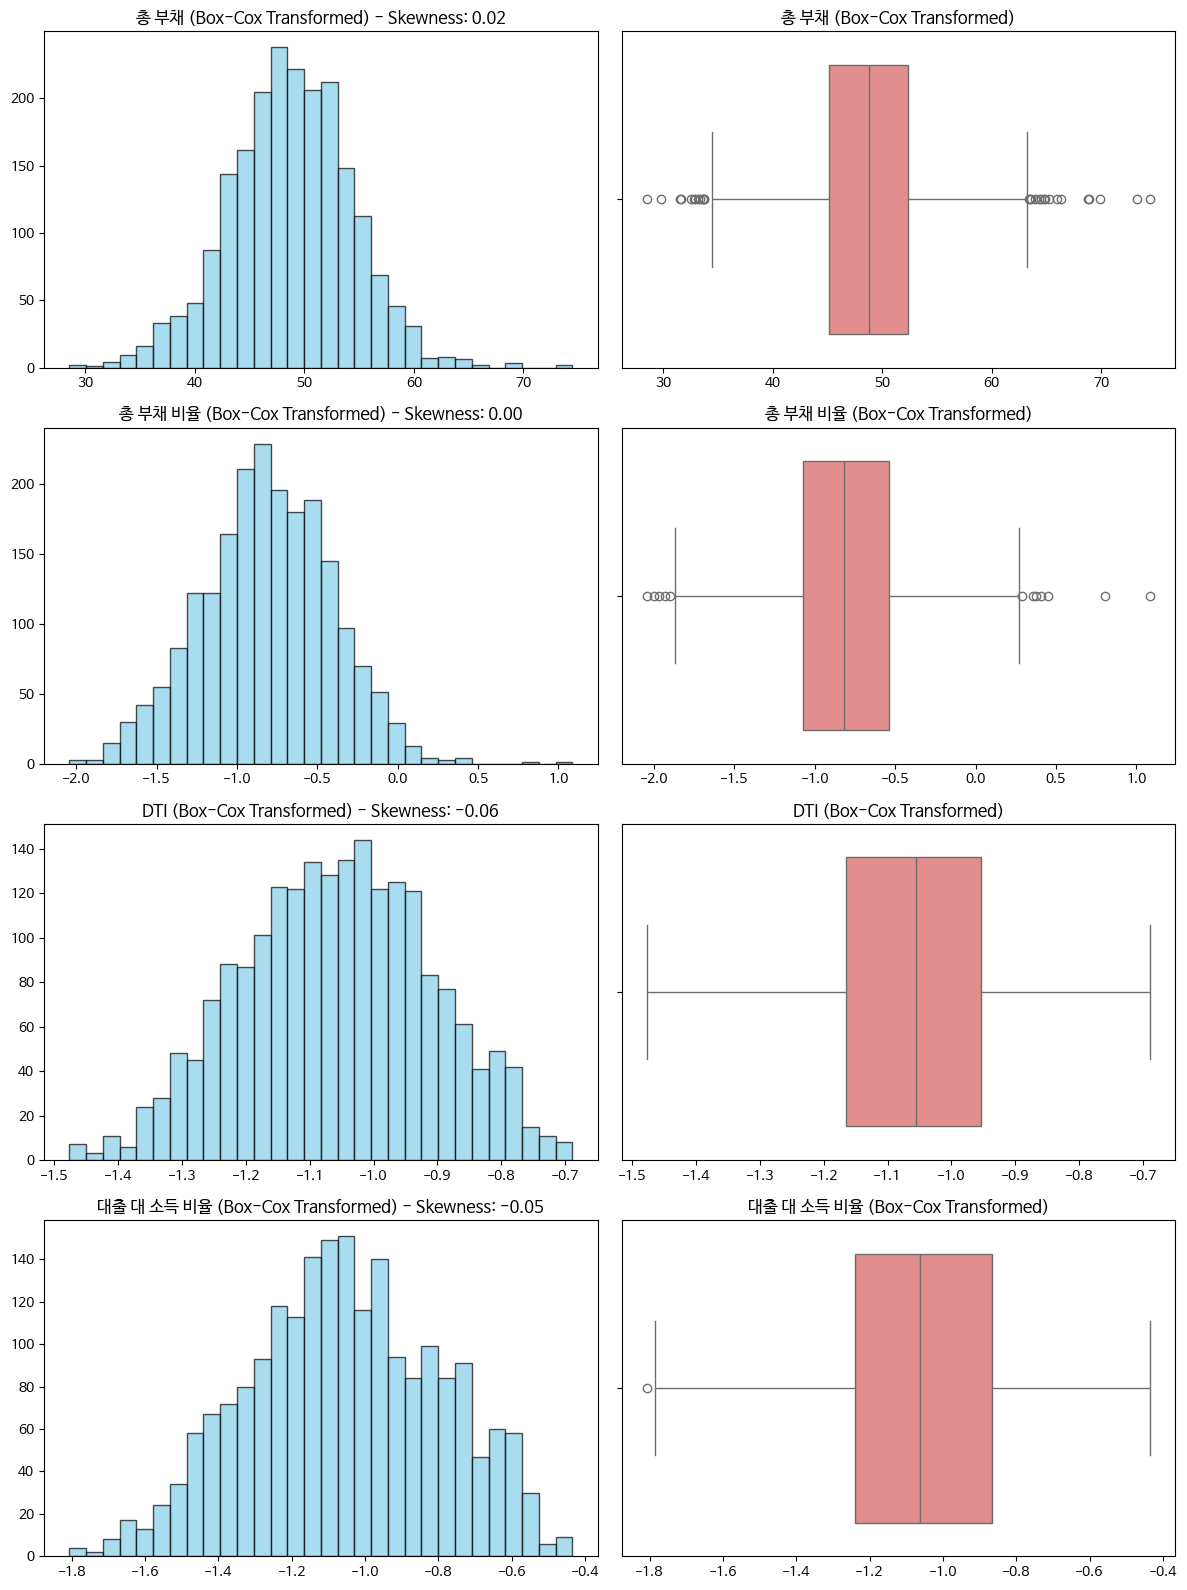

In [ ]:
### test 데이터에 대해서도 동일하게 진행
import scipy.stats as stats

# Box-Cox 변환이 가능한 수치형 컬럼 선택
numeric_cols = [
    "총 부채", "총 부채 비율", "DTI", "대출 대 소득 비율"
]

# 변환된 데이터를 저장할 딕셔너리
boxcox_transformed = {}

# 시각화 설정
plt.figure(figsize=(12, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    # 양수 값만 필터링 (Box-Cox 변환은 음수/0 값 불가능)
    positive_values = test[col][test[col] > 0]

    if len(positive_values) > 0:
        # Box-Cox 변환 수행
        transformed_data, lambda_ = stats.boxcox(positive_values)

        # 변환된 데이터 저장
        boxcox_transformed[col] = transformed_data

        # 왜도 계산
        skewness = stats.skew(transformed_data)

        # 시각화 (히스토그램 & 박스플롯)
        plt.subplot(len(numeric_cols), 2, 2 * i - 1)
        plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{col} (Box-Cox Transformed) - Skewness: {skewness:.2f}")

        plt.subplot(len(numeric_cols), 2, 2 * i)
        sns.boxplot(x=transformed_data, color='lightcoral')
        plt.title(f"{col} (Box-Cox Transformed)")

plt.tight_layout()
plt.show()

# 변수 간 관계 분석

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산 (연속형 변수만 선택)
X = train.select_dtypes(include=['float64', 'int64'])  # 숫자형 변수 선택
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

             Variable       VIF
0               연간 소득  0.009528
1         현재 직장 근속 연수  0.773297
2         체납 세금 압류 횟수  0.989443
3          개설된 신용계좌 수  0.603921
4            신용 거래 연수  0.615467
5             최대 신용한도  0.958914
6         신용 문제 발생 횟수  0.995839
7   마지막 연체 이후 경과 개월 수  0.562287
8            개인 파산 횟수  1.013528
9            현재 대출 잔액  0.141725
10         현재 미상환 신용액  0.270833
11           월 상환 부채액  0.481046
12              신용 점수  8.020115
13          채무 불이행 여부  0.884860
14               총 부채  0.078255
15            총 부채 비율  0.757322
16                DTI  0.313550
17         대출 대 소득 비율  0.574256
18                DSR  0.604549
19        신용카드 사용 집중도  0.797035
20             고위험 지표  0.995786
21       신용 이벤트 발생 빈도  0.990363
22        신규 계좌 개설 빈도  0.601011
23           대출목적_연체율  0.378638
24         1년 내 연체 여부  0.958193
25           연체 경험 여부  1.017199


In [ ]:
train.columns

Index(['주거 형태', '연간 소득', '현재 직장 근속 연수', '체납 세금 압류 횟수', '개설된 신용계좌 수',
       '신용 거래 연수', '최대 신용한도', '신용 문제 발생 횟수', '마지막 연체 이후 경과 개월 수', '개인 파산 횟수',
       '대출 목적', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수',
       '채무 불이행 여부', '총 부채', '총 부채 비율', 'DTI', '대출 대 소득 비율', 'DSR',
       '신용카드 사용 집중도', '고위험 지표', '신용 이벤트 발생 빈도', '신규 계좌 개설 빈도', '대출목적_연체율',
       '1년 내 연체 여부', '연체 경험 여부'],
      dtype='object')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# 숫자형 변수만 선택
numeric_train = train.select_dtypes(include=['number'])

# 모든 2개 조합의 변수 쌍 만들기
combinations = list(itertools.combinations(numeric_train.columns, 2))

# 변수 쌍별로 scatter plot 그리기
for var1, var2 in combinations:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=numeric_train, x=var1, y=var2, alpha=0.5)
    plt.title(f"Correlation between {var1} and {var2}")
    plt.show()


In [ ]:
import pandas as pd

# 숫자형 변수만 선택
numeric_train = train.select_dtypes(include=['number'])

# 피어슨 상관 계수 행렬 계산
correlation_matrix = numeric_train.corr(method='pearson')

# 특정 임계값(0.6 이상)인 변수들만 필터링 (자기 자신 제외)
high_corr = correlation_matrix[(correlation_matrix >= 0.6) & (correlation_matrix < 1.0)]

# NaN 값 제거 후 데이터프레임으로 변환
high_corr_df = high_corr.stack().reset_index()
high_corr_df.columns = ["Variable 1", "Variable 2", "Correlation"]

# 상관 계수 높은 순으로 정렬
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

# 결과 출력
print("🔹 상관 계수 0.6 이상인 변수들:")
print(high_corr_df)

🔹 상관 계수 0.6 이상인 변수들:
      Variable 1    Variable 2  Correlation
0         고위험 지표  신용 이벤트 발생 빈도     0.943781
1   신용 이벤트 발생 빈도        고위험 지표     0.943781
2         고위험 지표   신용 문제 발생 횟수     0.926129
3    신용 문제 발생 횟수        고위험 지표     0.926129
4   신용 이벤트 발생 빈도   신용 문제 발생 횟수     0.882579
5    신용 문제 발생 횟수  신용 이벤트 발생 빈도     0.882579
6       현재 대출 잔액          총 부채     0.823829
7           총 부채      현재 대출 잔액     0.823829
8        총 부채 비율    대출 대 소득 비율     0.822161
9     대출 대 소득 비율       총 부채 비율     0.822161
10           DTI           DSR     0.784633
11           DSR           DTI     0.784633
12        고위험 지표      개인 파산 횟수     0.767809
13      개인 파산 횟수        고위험 지표     0.767809
14    현재 미상환 신용액   신용카드 사용 집중도     0.745865
15   신용카드 사용 집중도    현재 미상환 신용액     0.745865
16          총 부채    현재 미상환 신용액     0.737002
17    현재 미상환 신용액          총 부채     0.737002
18      월 상환 부채액           DSR     0.722656
19           DSR      월 상환 부채액     0.722656
20      개인 파산 횟수  신용 이벤트 발생 빈도     0.714039
21  신용 이벤트 

# 범주형 변수 처리

In [ ]:
categorical_col = [
    '주거 형태',
    '대출 목적',
    '대출 상환 기간'
]
train = pd.get_dummies(train, columns=categorical_col)
test = pd.get_dummies(test, columns=categorical_col)

# 학습/테스트 데이터 분리

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

# ✅ 데이터 로드 (train, test가 이미 전처리되었다고 가정)
X = train.drop(columns=["채무 불이행 여부"])  # 특성 데이터
y = train["채무 불이행 여부"]  # 타겟 변수

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 불균형 해결

In [ ]:
# 5. SMOTE 적용 (훈련 데이터에만!)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 6. 결과 확인
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 5270, 1: 2730})
After SMOTE: Counter({0: 5270, 1: 5270})


# 모델 학습 및 하이퍼파라미터 튜닝

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# 추가된 모델들
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 🔹 랜덤 시드 및 KFold 설정
random_state = 2
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# 🔹 분류 모델 리스트 (추가된 모델 포함)
classifiers = [
    SVC(probability=True, random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    HistGradientBoostingClassifier(random_state=random_state),
    BaggingClassifier(random_state=random_state),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state),
    LGBMClassifier(random_state=random_state),
    CatBoostClassifier(verbose=0, random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis()
]

# 🔹 교차 검증 실행
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="roc_auc", cv=kfold))

# 🔹 ROC AUC 평균 및 표준편차 계산
cv_means = [cv_result.mean() for cv_result in cv_results]
cv_std = [cv_result.std() for cv_result in cv_results]

# 🔹 결과 저장 DataFrame
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValErrors": cv_std,
    "Algorithm": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
        "GradientBoosting", "HistGradientBoosting", "Bagging", "XGBoost",
        "LightGBM", "CatBoost", "MultipleLayerPerceptron", "KNeighboors",
        "LogisticRegression", "LinearDiscriminantAnalysis"
    ]
})

# 🔹 ROC AUC 기준 정렬
cv_res_sorted = cv_res.sort_values(by="CrossValMeans", ascending=False).reset_index(drop=True)

# 🔹 최종 결과 출력
print(cv_res_sorted[["Algorithm", "CrossValMeans"]])


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2184, number of negative: 4216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341250 -> initscore=-0.657729
[LightGBM] [Info] Start training from score -0.657729
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2184, number of negative: 4216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

## **하이퍼파라미터 튜닝**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Stratified K-Fold 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}
gb_model = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb_model, gb_params, cv=cv, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)

# LightGBM
lgb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
lgb_model = LGBMClassifier(random_state=42)
lgb_search = RandomizedSearchCV(lgb_model, lgb_params, cv=cv, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)

# Linear Discriminant Analysis
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}
lda_model = LinearDiscriminantAnalysis()
lda_search = RandomizedSearchCV(lda_model, lda_params, cv=cv, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)

# CatBoost (고유 GridSearch 사용)
cat_params = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}
cat_model = CatBoostClassifier(verbose=0, random_seed=42)

# 데이터 분할 (X_train, y_train 필요)
models = {'GradientBoosting': gb_search, 'LightGBM': lgb_search, 'LDA': lda_search}
for name, search in models.items():
    print(f"Tuning {name}...")
    search.fit(X_train, y_train)
    print(f"Best Params for {name}: {search.best_params_}")
    print(f"Best AUC Score: {search.best_score_:.4f}\n")

# CatBoost는 따로 실행
print("Tuning CatBoost...")
cat_model.grid_search(cat_params, X=X_train, y=y_train, cv=5, stratified=True, plot=True)


Tuning GradientBoosting...
Best Params for GradientBoosting: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
Best AUC Score: 0.7422

Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2730, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341250 -> initscore=-0.657729
[LightGBM] [Info] Start training from score -0.657729
Best Params for LightGBM: {'num_leaves': 20, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best AUC Score: 0.7391

Tuning LDA...
Best Params f

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6072344412
bestIteration = 99

0:	loss: 0.6072344	best: 0.6072344 (0)	total: 286ms	remaining: 1m 9s

bestTest = 0.5699139747
bestIteration = 99

1:	loss: 0.5699140	best: 0.5699140 (1)	total: 509ms	remaining: 1m 1s

bestTest = 0.5654469831
bestIteration = 96

2:	loss: 0.5654470	best: 0.5654470 (2)	total: 746ms	remaining: 59.7s

bestTest = 0.6077300914
bestIteration = 99

3:	loss: 0.6077301	best: 0.5654470 (2)	total: 971ms	remaining: 58s

bestTest = 0.5706505832
bestIteration = 99

4:	loss: 0.5706506	best: 0.5654470 (2)	total: 1.2s	remaining: 57.1s

bestTest = 0.5653901503
bestIteration = 92

5:	loss: 0.5653902	best: 0.5653902 (5)	total: 1.43s	remaining: 56.5s

bestTest = 0.6069129168
bestIteration = 99

6:	loss: 0.6069129	best: 0.5653902 (5)	total: 1.67s	remaining: 56.3s

bestTest = 0.5701794706
bestIteration = 99

7:	loss: 0.5701795	best: 0.5653902 (5)	total: 1.91s	remaining: 56.1s

bestTest = 0.5643704493
bestIteration = 99

8:	loss: 0.5643704	best: 0.5643704 (8)	total: 

{'params': {'border_count': 64,
  'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 3,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               

# **Best Model 학습**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Best Parameters 적용
best_gb = GradientBoostingClassifier(subsample=0.7, n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42)
best_lgb = LGBMClassifier(num_leaves=20, n_estimators=500, max_depth=10, learning_rate=0.01, colsample_bytree=0.7, random_state=42)
best_lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
best_cat = CatBoostClassifier(border_count=64, depth=4, learning_rate=0.1, l2_leaf_reg=3, iterations=200, verbose=0, random_seed=42)

# 모델 학습
print("Training GradientBoosting...")
best_gb.fit(X_train, y_train)
print("Training LightGBM...")
best_lgb.fit(X_train, y_train)
print("Training LDA...")
best_lda.fit(X_train, y_train)
print("Training CatBoost...")
best_cat.fit(X_train, y_train)

# 예측 및 평가
def evaluate_model(model, name):
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"{name} AUC Score: {auc_score:.4f}")

evaluate_model(best_gb, "GradientBoosting")
evaluate_model(best_lgb, "LightGBM")
evaluate_model(best_lda, "LDA")
evaluate_model(best_cat, "CatBoost")


Training GradientBoosting...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2730, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341250 -> initscore=-0.657729
[LightGBM] [Info] Start training from score -0.657729
Training LDA...
Training CatBoost...
GradientBoosting AUC Score: 0.7494
LightGBM AUC Score: 0.7461
LDA AUC Score: 0.7274
CatBoost AUC Score: 0.7472


## **Ensemble**

In [ ]:
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score

# Best Parameters 적용
best_gb = GradientBoostingClassifier(subsample=0.7, n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42)
best_lgb = LGBMClassifier(num_leaves=20, n_estimators=500, max_depth=10, learning_rate=0.01, colsample_bytree=0.7, random_state=42)
best_lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None)
best_cat = CatBoostClassifier(border_count=64, depth=4, learning_rate=0.1, l2_leaf_reg=3, iterations=200, verbose=0, random_seed=42)


# 🔹 Soft Voting Classifier 생성 (소프트 보팅 사용)
voting_clf2 = VotingClassifier(estimators=[
    #('catboost', best_cat),
    ('gbm', best_gb),
    #('hist_gbm', hist_gbm),
    #('lightgbm', lightgbm),
    ('lda', best_lda)
], voting='soft', n_jobs=-1)

# 🔹 모델 학습
voting_clf2.fit(X_train, y_train)

# 🔹 성능 평가 (ROC AUC)
y_pred_proba = voting_clf2.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"🔥 Voting Classifier ROC AUC Score: {auc_score:.4f}")


🔥 Voting Classifier ROC AUC Score: 0.7448


In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score


# 랜덤 시드 및 KFold 설정
random_state = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# CatBoost 하이퍼파라미터 탐색 범위 (각각 3개 후보)
param_grid = {
    "iterations": [300, 500, 700],
    "learning_rate": [0.05, 0.1, 0.2],
    "depth": [6, 8, 10],
    "l2_leaf_reg": [1, 3, 5],
}

# CatBoost 모델 객체 초기화
catboost = CatBoostClassifier(verbose=0, random_state=random_state)

# GridSearchCV를 이용한 하이퍼파라미터 최적화
search = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=kfold,
    n_jobs=-1
)

# 모델 학습 (튜닝 수행)
search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print(f"✅ 최적 하이퍼파라미터: {search.best_params_}")

# 최적 모델 성능 확인
best_catboost = search.best_estimator_
y_pred_proba = best_catboost.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"🔥 최적 CatBoost ROC AUC Score: {auc_score:.4f}")


KeyboardInterrupt: 

In [ ]:
# 🔹 LightGBM Classifier 하이퍼파라미터 튜닝
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 5, 7]  # LightGBM은 -1이 자동설정
}

lgbm_model = LGBMClassifier(random_state=42)
lgbm_search = GridSearchCV(lgbm_model, lgbm_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
lgbm_search.fit(X_train, y_train)

y_val_pred_proba_lgbm = lgbm_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc_lgbm = roc_auc_score(y_val, y_val_pred_proba_lgbm)

print("🔹 Best LightGBM Params:", lgbm_search.best_params_)
print(f"🔹 Best CV ROC AUC (LightGBM): {lgbm_search.best_score_:.4f}")
print(f"🔹 Validation ROC AUC (LightGBM): {val_auc_lgbm:.4f}")

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 하이퍼파라미터 그리드
param_grid = {
    'solver': ['svd', 'lsqr']
}

# 모델 및 GridSearchCV 실행
lda_model = LinearDiscriminantAnalysis()
lda_search = GridSearchCV(lda_model, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
lda_search.fit(X_train, y_train)

# 최적 모델 평가
y_val_pred_proba = lda_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print("Best LDA Params:", lda_search.best_params_)
print(f"Best CV ROC AUC: {lda_search.best_score_:.4f}")
print(f"Validation ROC AUC: {val_auc:.4f}")


In [ ]:
# 🔹 HistGradientBoosting Classifier 하이퍼파라미터 튜닝
hgb_param_grid = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

hgb_model = HistGradientBoostingClassifier(random_state=42)
hgb_search = GridSearchCV(hgb_model, hgb_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
hgb_search.fit(X_train, y_train)

y_val_pred_proba_hgb = hgb_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc_hgb = roc_auc_score(y_val, y_val_pred_proba_hgb)

print("🔹 Best HistGradientBoosting Params:", hgb_search.best_params_)
print(f"🔹 Best CV ROC AUC (HistGradientBoosting): {hgb_search.best_score_:.4f}")
print(f"🔹 Validation ROC AUC (HistGradientBoosting): {val_auc_hgb:.4f}")

🔹 Best HistGradientBoosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
🔹 Best CV ROC AUC (HistGradientBoosting): 0.7397
🔹 Validation ROC AUC (HistGradientBoosting): 0.7519


In [ ]:
# 🔹 RandomForest 하이퍼파라미터 그리드
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# 🔹 RandomForest Classifier 하이퍼파라미터 튜닝
rf_model = RandomForestClassifier(random_state=42)
rf_search = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
rf_search.fit(X_train, y_train)

y_val_pred_proba_rf = rf_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)

print("🔹 Best RandomForest Params:", rf_search.best_params_)
print(f"🔹 Best CV ROC AUC (RandomForest): {rf_search.best_score_:.4f}")
print(f"🔹 Validation ROC AUC (RandomForest): {val_auc_rf:.4f}\n")

🔹 Best RandomForest Params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
🔹 Best CV ROC AUC (RandomForest): 0.7371
🔹 Validation ROC AUC (RandomForest): 0.7405





---



In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# 🔹 베이스 모델들 설정 (선택한 6개 모델)
base_learners = [
    ('gb', GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 100, random_state=42)),
    ('cat', CatBoostClassifier(depth= 7, iterations= 300, learning_rate= 0.01, random_state=42)),
    #('lgbm', LGBMClassifier(learning_rate= 0.01, max_depth= 7, n_estimators= 300, random_state=42)),
    #('histgb', HistGradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_iter= 100, random_state=42)),
    #('rf', RandomForestClassifier(max_depth= 10, min_samples_leaf= 5, min_samples_split= 2, n_estimators= 300, random_state=42)),
    #('lda', LinearDiscriminantAnalysis(solver= 'svd'))
]

# 🔹 메타 모델 설정 (Logistic Regression 사용)
meta_model = LogisticRegression(random_state=42)

# 🔹 스태킹 분류기 생성
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)

# 🔹 모델 학습
stacking_clf.fit(X_train, y_train)

# 🔹 성능 평가 (ROC AUC)
y_pred_proba = stacking_clf.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"🔥 Stacking Classifier ROC AUC Score: {auc_score:.4f}")


🔥 Stacking Classifier ROC AUC Score: 0.7390


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# 🔹 상위 3개 모델 (예제: 아까 뽑은 성능 상위 모델들)
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
cat = CatBoostClassifier(iterations=300, learning_rate=0.01, depth=7, verbose=0, random_state=42)
#lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.01, max_depth=7, random_state=42)
#lda=  LinearDiscriminantAnalysis(solver= 'svd')
#rf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 5, min_samples_split= 2, n_estimators= 300, random_state=42)

# 🔹 Soft Voting Classifier 생성 (소프트 보팅 사용)
voting_clf = VotingClassifier(estimators=[
    ('gbm', gbm),
    ('cat', cat),
    #('lgbm', lgbm),
    #('lda', lda),
    #('rf', rf)
], voting='soft')

# 🔹 모델 학습
voting_clf.fit(X_train, y_train)

# 🔹 성능 평가 (ROC AUC)
y_pred_proba = voting_clf.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"🔥 Voting Classifier ROC AUC Score: {auc_score:.4f}")


🔥 Voting Classifier ROC AUC Score: 0.7393


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_gb_model = gb_search.best_estimator_

# 피처 중요도 가져오기
# Feature Importance 가져오기
feature_importance = best_gb_model.feature_importances_

# 피처 중요도를 데이터프레임으로 변환 (X_train의 컬럼 이름과 매칭)
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # 피처 이름
    'Importance': feature_importance  # 중요도 값
})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 출력
print(feature_importance_df)


                   Feature  Importance
21             신규 계좌 개설 빈도    0.147851
22                대출목적_연체율    0.121490
0                    연간 소득    0.079652
3               개설된 신용계좌 수    0.076528
12                   신용 점수    0.068134
20            신용 이벤트 발생 빈도    0.064173
13                    총 부채    0.058427
9                 현재 대출 잔액    0.054344
10              현재 미상환 신용액    0.042543
16              대출 대 소득 비율    0.036992
43          대출 상환 기간_단기 상환    0.032221
44          대출 상환 기간_장기 상환    0.030124
7        마지막 연체 이후 경과 개월 수    0.027588
8                 개인 파산 횟수    0.024901
5                  최대 신용한도    0.019048
11                월 상환 부채액    0.017118
14                 총 부채 비율    0.015750
6              신용 문제 발생 횟수    0.012467
18             신용카드 사용 집중도    0.011734
17                     DSR    0.010706
1              현재 직장 근속 연수    0.010645
25                주거 형태_월세    0.010595
4                 신용 거래 연수    0.008328
15                     DTI    0.006648
28  주거 형태_주택 담보 대출 (비거주 중

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 모델 및 GridSearchCV 실행
et_model = ExtraTreesClassifier()
et_search = GridSearchCV(et_model, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
et_search.fit(X_train, y_train)

# 최적 모델 평가
y_val_pred_proba = et_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred_proba)

print("Best ExtraTrees Params:", et_search.best_params_)
print(f"Best CV ROC AUC: {et_search.best_score_:.4f}")
print(f"Validation ROC AUC: {val_auc:.4f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# ✅ RandomForest 하이퍼파라미터 그리드 설정
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7, None],  # 트리 최대 깊이 (None은 완전 성장)
    'min_samples_split': [2, 5, 10],  # 노드를 분할하는 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드가 될 수 있는 최소 샘플 수
}

# ✅ RandomForest 모델 및 GridSearchCV 실행
rf_model = RandomForestClassifier(random_state=42)
rf_search = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
rf_search.fit(X_train, y_train)

# ✅ 최적 모델 평가 (검증 데이터)
y_val_pred_proba_rf = rf_search.best_estimator_.predict_proba(X_val)[:, 1]
val_auc_rf = roc_auc_score(y_val, y_val_pred_proba_rf)

# ✅ 결과 출력
print("Best RandomForest Params:", rf_search.best_params_)
print(f"Best CV ROC AUC: {rf_search.best_score_:.4f}")
print(f"Validation ROC AUC: {val_auc_rf:.4f}")


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLDA.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

# prediction

In [ ]:
preds = voting_clf2.predict_proba(test)[:, 1]

# submission

In [ ]:
# 결과 저장

submit = pd.read_csv('/content/drive/MyDrive/YB_project/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds
submit.to_csv('./submission_0303_4.csv', encoding='UTF-8-sig', index=False)